# L-R Asymmetries in brain3

see [2023-08-29_sections_1199651045_048_asymmetry.pptx](https://alleninstitute.sharepoint.com/:p:/s/U19Thalamus/EUnDEPa5Cl1DqPJOTy8mVX4B2e2vdE6V54bPOSG-XnLzDQ?e=EUxCIA) in U19 Thalamus - Project 2 - Reports folder for more details

**Issue that prompted this notebook:**
- In general, SpaGCN picks up on L-R symmetries, giving the same labels to domains in the R hemisphere as to the L hemisphere
- But, in two sections [1199651048, 1199651045] of brain3, SpaGCN assigns *different* domain IDs to what should be identical regions of the left vs right hemispheres 
- Initializing SpaGCN with fewer clusters does not fully alleviate the asymmetry
- See [thalamus-merfish-spaGCN capsule](https://codeocean.allenneuraldynamics.org/capsule/0220088/tree) for those results

**Why is this happening?**
- Low transcript detection and/or missing cells in the right hemispheres of both sections
    - These sections were kept & analyzed for the WMB atlas, despite poor right hemisphere quality, because the left hemisphere was deemed good enough quality to still use

**In what other analyses does this issue appear?**
- L-R asymmetry does NOT appear significantly in cell type mapping
    - see [insert] in this capsule for these results
- L-R asymmetry DOES appear in NMF & spatial factorization analyses 
    - see [merfish-spatial-factorization_mat-copy capsule](https://codeocean.allenneuraldynamics.org/capsule/8871728/tree) for these results

**Conclusion:**
- Going forward, conduct MERFISH gene expression analyses & interpretation on only the left hemispheres of sections 1199651048 & 1199651045
- Probably best to also subset all sections to just the left hemisphere so analyses can be run identically on all sections
    - Can then take the mirror image of the right hemispheres and treat them as n=2
    - NOT recommended to mirror the "good" left hemispheres into the "bad" right hemispheres - basically duplicating data

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import seaborn as sns
from scipy import sparse, stats
from sklearn import linear_model, datasets

%matplotlib inline 

# Load brain3 adata

In [2]:
adata_brain3 = ad.read_h5ad("/root/capsule/data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad") 

In [3]:
genes = sorted([x for x in adata_brain3.var_names if 'Blank' not in x])
blanks = sorted([x for x in adata_brain3.var_names if 'Blank' in x])

adata_brain3 = adata_brain3[:,genes].copy()
# adata_brain3

# Split the cells into L vs R hemisphere

Using an approximate method for now so I can do these diagnostic analyses quickly: find bounding box that contains all cells & then use the halfway point on the x-axis as the approx. midline

TODO: use the CCF-aligned polygons for a more accurate division

In [4]:
# Assign each cell to the left or right hemisphere
for sec in adata_brain3.obs['section'].unique():
    # get the x-coordinates of all cells in this section
    x_coords = adata_brain3.obsm['spatial_cirro'][adata_brain3.obs['section']==sec,0]
    
    # option 1 (best): find bounding box & use halfway as midline
    min_x = np.min(x_coords)
    max_x = np.max(x_coords)
    x_midpoint = (min_x + max_x) / 2
    
#     # option 2: mean x coord
#     x_midpoint = np.mean(x_coords)
    
#     # option 2: median x coord
#     x_midpoint = np.median(x_coords)
    
    # classify each cell as left or right
    adata_brain3.obs.loc[adata_brain3.obs['section']==sec, 'left_right'] = np.where(x_coords < x_midpoint, 'left', 'right')

In [5]:
# split left and right into their own anndata objects for ease of use
left_hemi_ad = adata_brain3[adata_brain3.obs['left_right']=='left']
right_hemi_ad = adata_brain3[adata_brain3.obs['left_right']=='right']

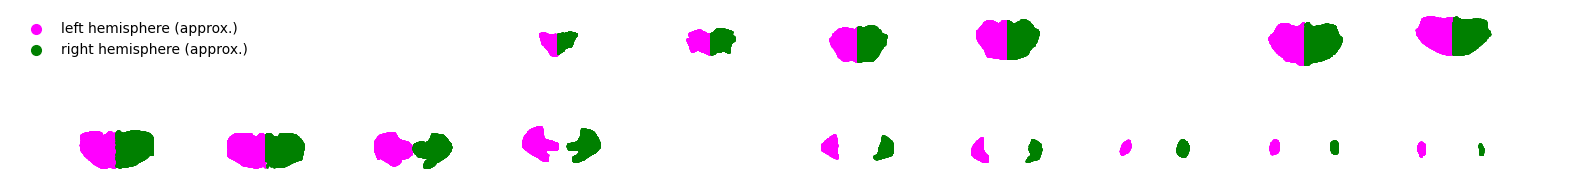

In [6]:
# Sanity check that our approx. method of detecting the midline work okay
fig = plt.figure(figsize=(20,8))

# for sec in adata_brain3.obs['section'].unique():
ax = plt.gca()

# plot left vs right cells in different colors
ax.scatter(left_hemi_ad.obsm['spatial_cirro'][:,0], 
           left_hemi_ad.obsm['spatial_cirro'][:,1],
           c='magenta', s=1, label='left hemisphere (approx.)')
ax.scatter(right_hemi_ad.obsm['spatial_cirro'][:,0], 
           right_hemi_ad.obsm['spatial_cirro'][:,1],
           c='green', s=1, label='right hemisphere (approx.)')
ax.set_aspect('equal', 'box')
ax.legend(loc='upper left', markerscale=7, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)

# L vs R metrics

In [7]:
sec_ids = adata_brain3.obs['section'].unique().tolist()

# Store metrics in a per-section dataframe
sec_properties_df = pd.DataFrame(index=sec_ids)

## total # of cells in L vs R hemisphere

### calculate

In [8]:
# Count the number of cells in each hemisphere
for sec in sec_ids:
    n_cells_left = sum((adata_brain3.obs['section']==sec) & 
                       (adata_brain3.obs['left_right']=='left')
                      )
    n_cells_right = sum((adata_brain3.obs['section']==sec) & 
                        (adata_brain3.obs['left_right']=='right')
                       )
    n_cells_pct_diff = (abs(n_cells_left - n_cells_right) / ((n_cells_left + n_cells_right) / 2)) * 100
    
    sec_properties_df.loc[sec,'n_cells_left'] = n_cells_left
    sec_properties_df.loc[sec,'n_cells_right'] = n_cells_right
    sec_properties_df.loc[sec,'n_cells_pct_diff'] = n_cells_pct_diff
    

sec_properties_df['n_cells_left'] = sec_properties_df['n_cells_left'].astype(int)
sec_properties_df['n_cells_right'] = sec_properties_df['n_cells_right'].astype(int)

### plot

In [9]:
sns.color_palette("hls", len(sec_ids))

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5791999999999999, 0.33999999999999997),
 (0.86, 0.7872, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5167999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7872000000000001),
 (0.33999999999999997, 0.7247999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.5791999999999999, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7247999999999996),
 (0.86, 0.33999999999999997, 0.5167999999999995)]

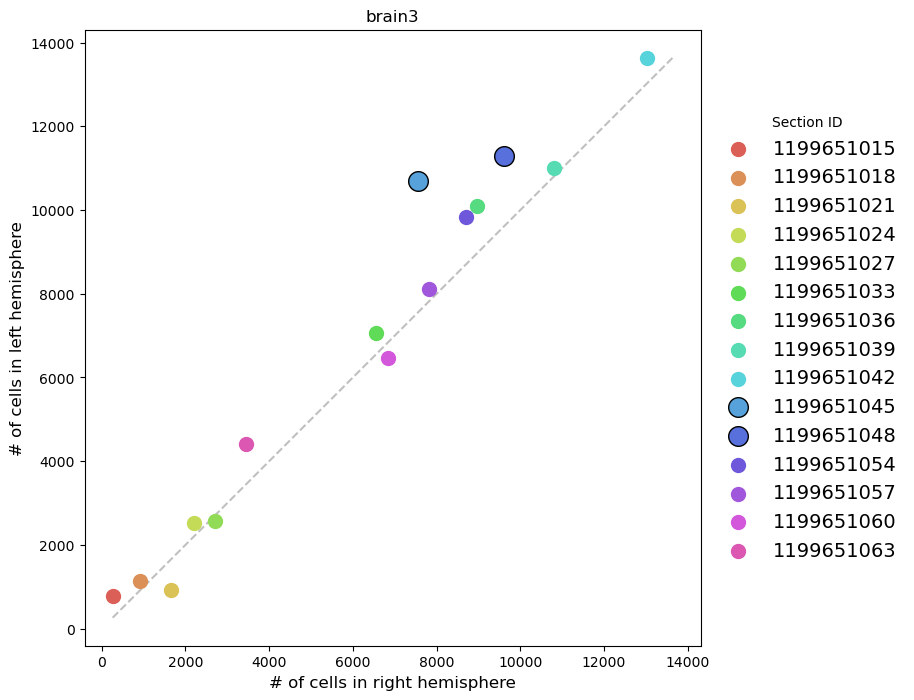

In [10]:
# Plot L vs R total # of cells per hemisphere
fig, ax = plt.subplots(figsize=(8,8))

colors = sns.color_palette("hls", len(sec_ids)+1)


xymin = np.min([sec_properties_df['n_cells_left'].min(), 
               sec_properties_df['n_cells_right'].min()])
xymax = np.max([sec_properties_df['n_cells_left'].max(), 
               sec_properties_df['n_cells_right'].max()])
ax.plot([xymin,xymax], [xymin,xymax], color='silver', linestyle='--',zorder=0)

for i in range(len(sec_properties_df)):
    # highlight the two problematic sections
    if sec_ids[i] in ['1199651045', '1199651048']:
        ax.scatter(sec_properties_df['n_cells_right'][i], 
                   sec_properties_df['n_cells_left'][i], 
                   s=200, color=colors[i], label=sec_ids[i],
                   edgecolors='black')
    else:
        ax.scatter(sec_properties_df['n_cells_right'][i], 
                   sec_properties_df['n_cells_left'][i], 
                   s=100, color=colors[i], label=sec_ids[i])

# Create a legend for all the scatter points
ax.set_aspect('equal', 'box')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc="center left", bbox_to_anchor=(1.,0.5), title="Section ID", 
          fontsize=14, frameon=False)

ax.set_xlabel('# of cells in right hemisphere', fontsize=12)
ax.set_ylabel('# of cells in left hemisphere', fontsize=12)
plt.title('brain3')
plt.show()

## Gene expression based metrics

total reads, mean expression, median expression, 95th & 99th percentile expression, number of cells expressing, fraction of cells expressing

### calculate expression metrics

In [11]:
# dictionary to store each section's metrics as a separate, gene-by-metric df
section_LR_properties = {}

# Calculate all the gene expression-based metrics
for sec in sec_ids:
    gene_expr_left = adata_brain3[(adata_brain3.obs['section']==sec) & 
                                  (adata_brain3.obs['left_right']=='left')].X.A
    gene_expr_right = adata_brain3[(adata_brain3.obs['section']==sec) & 
                                   (adata_brain3.obs['left_right']=='right')].X.A
    
    # Calculate the number of cells in sec_adata_left and sec_adata_right
    num_cells_left = gene_expr_left.shape[0]
    num_cells_right = gene_expr_right.shape[0]
    
    # Calculate expression metrics for each gene (gene axis=0)
    # total reads
    total_reads_left = np.sum(gene_expr_left, axis=0)
    total_reads_right = np.sum(gene_expr_right, axis=0)
    # mean
    mean_left = np.mean(gene_expr_left, axis=0)
    mean_right = np.mean(gene_expr_right, axis=0)
    # median
    median_left = np.median(gene_expr_left, axis=0)
    median_right = np.median(gene_expr_right, axis=0)
    # 95th percentile expression
    pct = 95
    pct95_left = np.percentile(gene_expr_left, q=pct, axis=0)
    pct95_right = np.percentile(gene_expr_right, q=pct, axis=0)
    # 99th percentile expression
    pct = 95
    pct99_left = np.percentile(gene_expr_left, q=pct, axis=0)
    pct99_right = np.percentile(gene_expr_right, q=pct, axis=0)
    # number of cells expressing each gene
    n_cells_expr_left = np.sum(gene_expr_left > 0, axis=0)
    n_cells_expr_right = np.sum(gene_expr_right > 0, axis=0)
    
    # Create a dictionary to store the results
    gene_data = {
                 # total reads
                 'total_reads_left': total_reads_left,
                 'total_reads_right': total_reads_right,
                 # mean
                 'mean_left': mean_left,
                 'mean_right': mean_right,
                 'mean_left_per_cell': mean_left / num_cells_left,
                 'mean_right_per_cell': mean_right / num_cells_right,
                 # median
                 'median_left': median_left,
                 'median_right': median_right,
                 'median_left_per_cell': median_left / num_cells_left,
                 'median_right_per_cell': median_right / num_cells_right,
                 # 95th percentile
                 '95pct_left': pct95_left,
                 '95pct_right': pct95_right,
                 '95pct_left_per_cell': pct95_left / num_cells_left,
                 '95pct_right_per_cell': pct95_right / num_cells_right,
                 # 99th percentile
                 '99pct_left': pct99_left,
                 '99pct_right': pct99_right,
                 '99pct_left_per_cell': pct99_left / num_cells_left,
                 '99pct_right_per_cell': pct99_right / num_cells_right,
                 # fraction of cells that are expressing
                 'n_cells_expr_left': n_cells_expr_left,
                 'n_cells_expr_right': n_cells_expr_right,
                 'frac_cells_expr_left': n_cells_expr_left / num_cells_left,
                 'frac_cells_expr_right': n_cells_expr_right / num_cells_right
                }

    # Convert the dictionary to a DataFrame
    sec_df = pd.DataFrame(gene_data, index=genes)
    
    # Add to per-section dictionary
    section_LR_properties[sec] = sec_df
    
# section_LR_properties

In [12]:
# # uncomment to see the format of this df
# section_LR_properties['1199651048']

### plot_left_vs_right_hemisphere_metric()

In [13]:
def plot_left_vs_right_hemisphere_metric(section_LR_properties, sec_ids, 
                                         property_col_left, property_col_right,
                                         property_name_str, genes_to_highlight=[], 
                                         xymin=None, xymax=None):
    '''
    Plot left vs right hemisphere metrics.
    
    Parameters
    ----------
    section_LR_properties: dictionary of Pandas dataframes
        as generated earlier in this notebook
    
    sec_ids: list of strings
        IDs of sections to generate plots for
    
    property_col_left, property_col_right:
        name of df columns to plot
    
    property_name_str: string
        name of the property as you want it to appear as the title of the plot
        
    genes_to_highlight: list of strings
        names of genes that will be plotted larger & in a different color
        
    Returns
    ------
    fig: Matplotlib figure
    
    '''
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.2)

    for i, sec_id_str in enumerate(sec_ids):
        # get the current section from the dictionary
        sec_df = section_LR_properties[sec_id_str]
        genes = sec_df.index.tolist()

        ax = axs[i]  # Select the current subplot

        ax.scatter(sec_df.loc[:, property_col_right], 
                   sec_df.loc[:, property_col_left],
                   s=10, zorder=0, alpha=0.5, label='brain3 genes')

        for gene in genes:
            # highlight specified genes - larger, different colors, labeled
            if gene in genes_to_highlight:
                ax.scatter(sec_df.loc[gene, property_col_right], 
                           sec_df.loc[gene, property_col_left],
                           s=200, zorder=3, label=gene, edgecolors='k')
        # only show legend for leftmost plot (no need to plot more than once)
        if i==0:
            ax.legend(loc='lower left', bbox_to_anchor=(0.1,1.1), ncol=2,
                      frameon=True, fontsize=14)
        # other plot parameters    
        ax.set_aspect('equal', 'box')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('right hemisphere', fontsize=16)
        ax.set_ylabel('left hemisphere', fontsize=16)
        ax.set_xlim(xymin, xymax)
        ax.set_ylim(xymin, xymax)
        ax.plot([0, xymax], [0, xymax], color='k', linestyle='--', zorder=2) # tuck 1:1 line behind highlighted genes
        ax.set_title('section ' + sec_id_str, fontsize=16)
    
    plt.suptitle(property_name_str, fontsize=20)
    plt.tight_layout() #rect=[0, 0.03, 1, 0.95])  # set aside space for suptitle
    plt.show()
    
    return fig

### RANSAC outlier detection - plot_left_vs_right_ransac()

In [14]:
def plot_left_vs_right_ransac(section_LR_properties, sec_ids, 
                                         property_col_left, property_col_right,
                                         property_name_str, log_scale=False,
                                         xymin=None, xymax=None):
    '''
    Plot left vs right hemisphere metrics w/ a RANSAC fit & outliers highlighted
    
    Parameters
    ----------
    section_LR_properties: dictionary of Pandas dataframes
        as generated earlier in this notebook
    
    sec_ids: list of strings
        IDs of sections to generate plots for
    
    property_col_left, property_col_right:
        name of df columns to plot
    
    property_name_str: string
        name of the property as you want it to appear as the title of the plot
        
    log_scale: boolean
        whether the axes will be displayed in log scale
        
    Returns
    ------
    fig: Matplotlib figure
    
    '''
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.2)

    for i, sec_id_str in enumerate(sec_ids):
        # get the current section from the dictionary
        sec_df = section_LR_properties[sec_id_str]
        genes = sec_df.index.tolist()
        left = sec_df.loc[:, property_col_left].to_numpy()
        right = sec_df.loc[:, property_col_right].to_numpy()

        ax = axs[i]  # Select the current subplot
        
        # RANSAC linear fit & outlier detection
        ransac = linear_model.RANSACRegressor()
        ransac.fit(right.reshape(-1, 1), left)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        y_intercept = round(ransac.estimator_.intercept_,2)
        slope = round(ransac.estimator_.coef_[0],2)
        
        # Predict data of estimated models
        if (xymax < 100):
            # use linspace when we need to use non-integer floating pt #s
            fit_line_x = np.linspace(xymin, xymax)[:, np.newaxis]
        else:
            # otherwise, stick with the integers arange generates
            fit_line_x = np.arange(xymin, xymax)[:, np.newaxis]   
            
        fit_line_y_ransac = ransac.predict(fit_line_x)
    
        # Plot inliers & outliers in different colors
        ax.scatter(right[inlier_mask], left[inlier_mask],
                   s=10, zorder=0, alpha=0.5, color='yellowgreen', 
                   label='inlier genes')
        ax.scatter(right[outlier_mask], left[outlier_mask],
                   s=10, zorder=0, alpha=0.5, color='gold', 
                   label='outlier genes')
        
        # plot RANSAC linear fit line
        LINE_WIDTH = 2
        equation_str = 'y = ' + str(y_intercept) + ' + ' + str(slope) + 'x'
        ax.plot(fit_line_x, fit_line_y_ransac, color='cornflowerblue',
                linestyle='--', linewidth=LINE_WIDTH, 
                label='RANSAC regressor\n'+equation_str)
        # # annotate with slope
        # ax.text((xymin+10)*1.3, xymax*0.7,
        #         fontsize=14)
        
        # plot 1:1 line
        ax.plot([0, xymax], [0, xymax], color='k', zorder=2,
                linestyle='--', linewidth=LINE_WIDTH, label='y = x')

        # only show legend for leftmost plot (no need to plot more than once)
        ax.legend(loc='lower left', bbox_to_anchor=(0.,1.1), ncol=2,
                  frameon=True, fontsize=14, markerscale=4.0)
        # other plot parameters    
        ax.set_aspect('equal', 'box')
        if log_scale:
            ax.set_xscale('log')
            ax.set_yscale('log')
        ax.set_xlabel('right hemisphere', fontsize=16)
        ax.set_ylabel('left hemisphere', fontsize=16)
        ax.set_xlim(xymin, xymax)
        ax.set_ylim(xymin, xymax)
        ax.set_title('section ' + sec_id_str, fontsize=16)
    
    plt.suptitle(property_name_str, fontsize=20)
    plt.tight_layout() #rect=[0, 0.03, 1, 0.95])  # set aside space for suptitle
    plt.show()
    
    return fig

### set plotting parameters

In [15]:
genes_to_highlight = ['Bnc1', 'Cldn5', 'Lpar1', 'Nrp1', # noticeably asymmetric, 'Whrn'
                      'Pou6f2', 'St6galnac5' # not very noticeable
                     ]

# list anterior to posterior to match gene expression scatter plots
sec_to_plot = [
               '1199651054', # reasonable-looking section for comparison
               '1199651048', # problematic section
               '1199651045', # problematic section
               '1199651042'  # reasonable-looking section for comparison
              ]

### total gene reads

In [16]:
# Total gene reads
property_col_left = 'total_reads_left'
property_col_right = 'total_reads_right'
property_name = 'Total gene reads'
XY_MIN = 10
XY_MAX = 60000

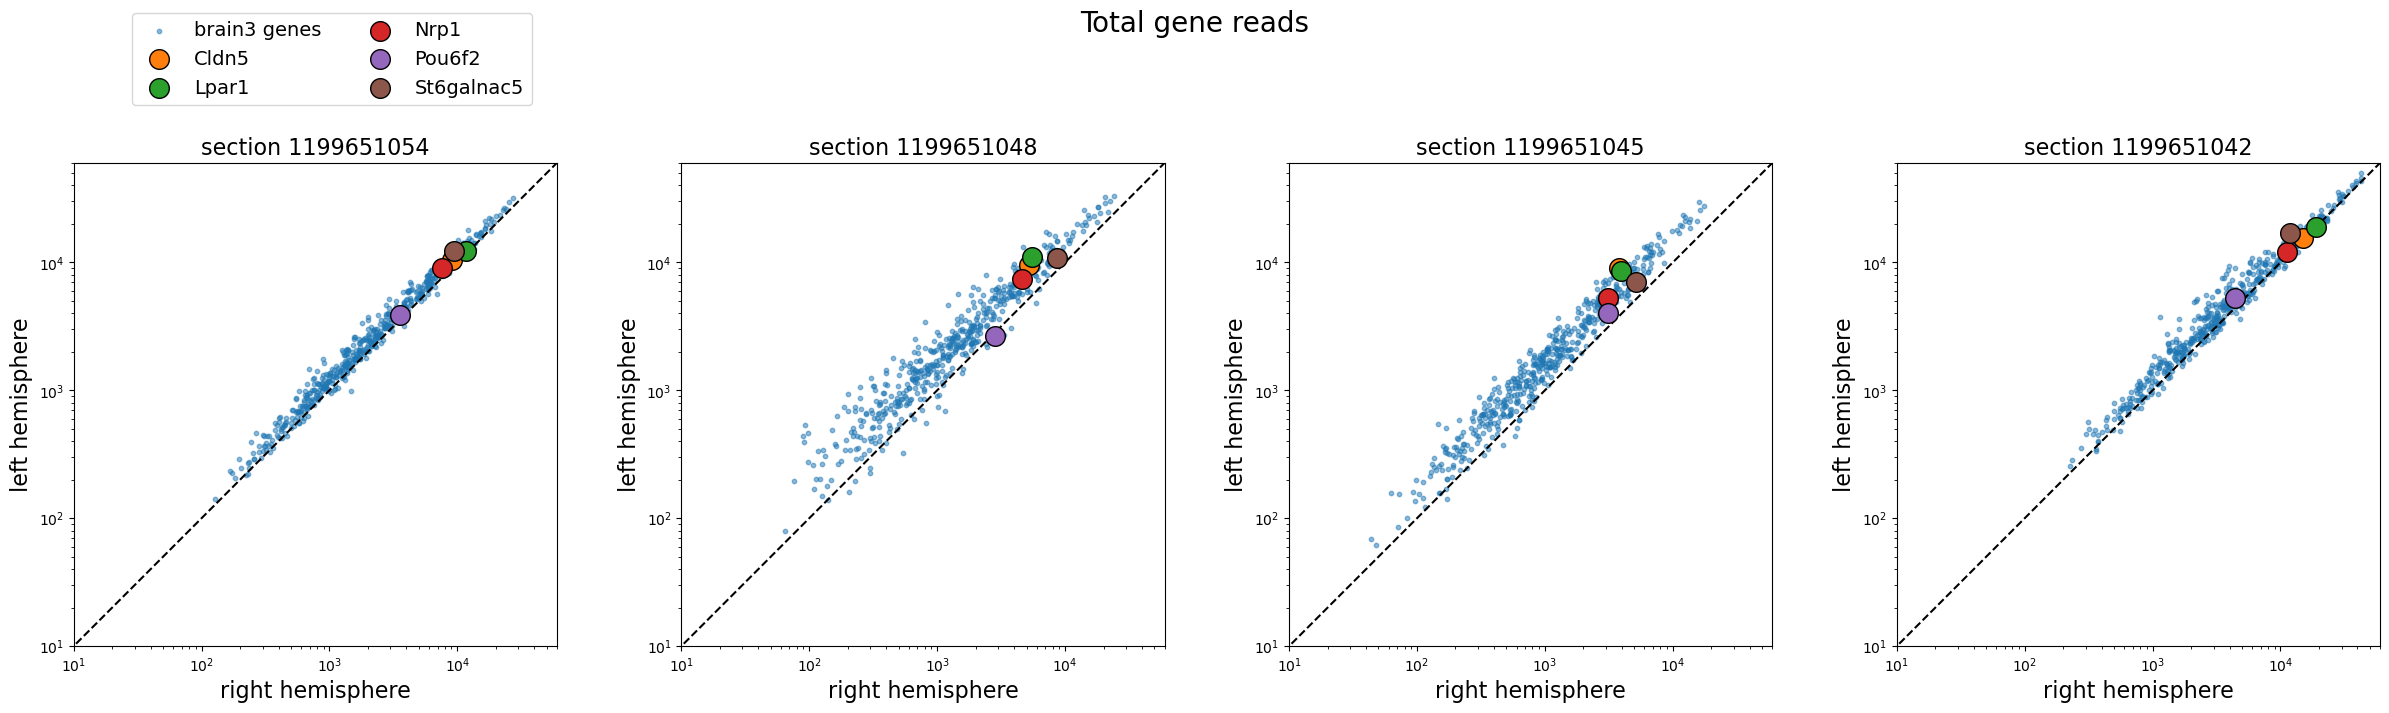

In [17]:
# Total gene reads - with genes highlighted
fig_tot_reads = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymin=XY_MIN,xymax=XY_MAX)

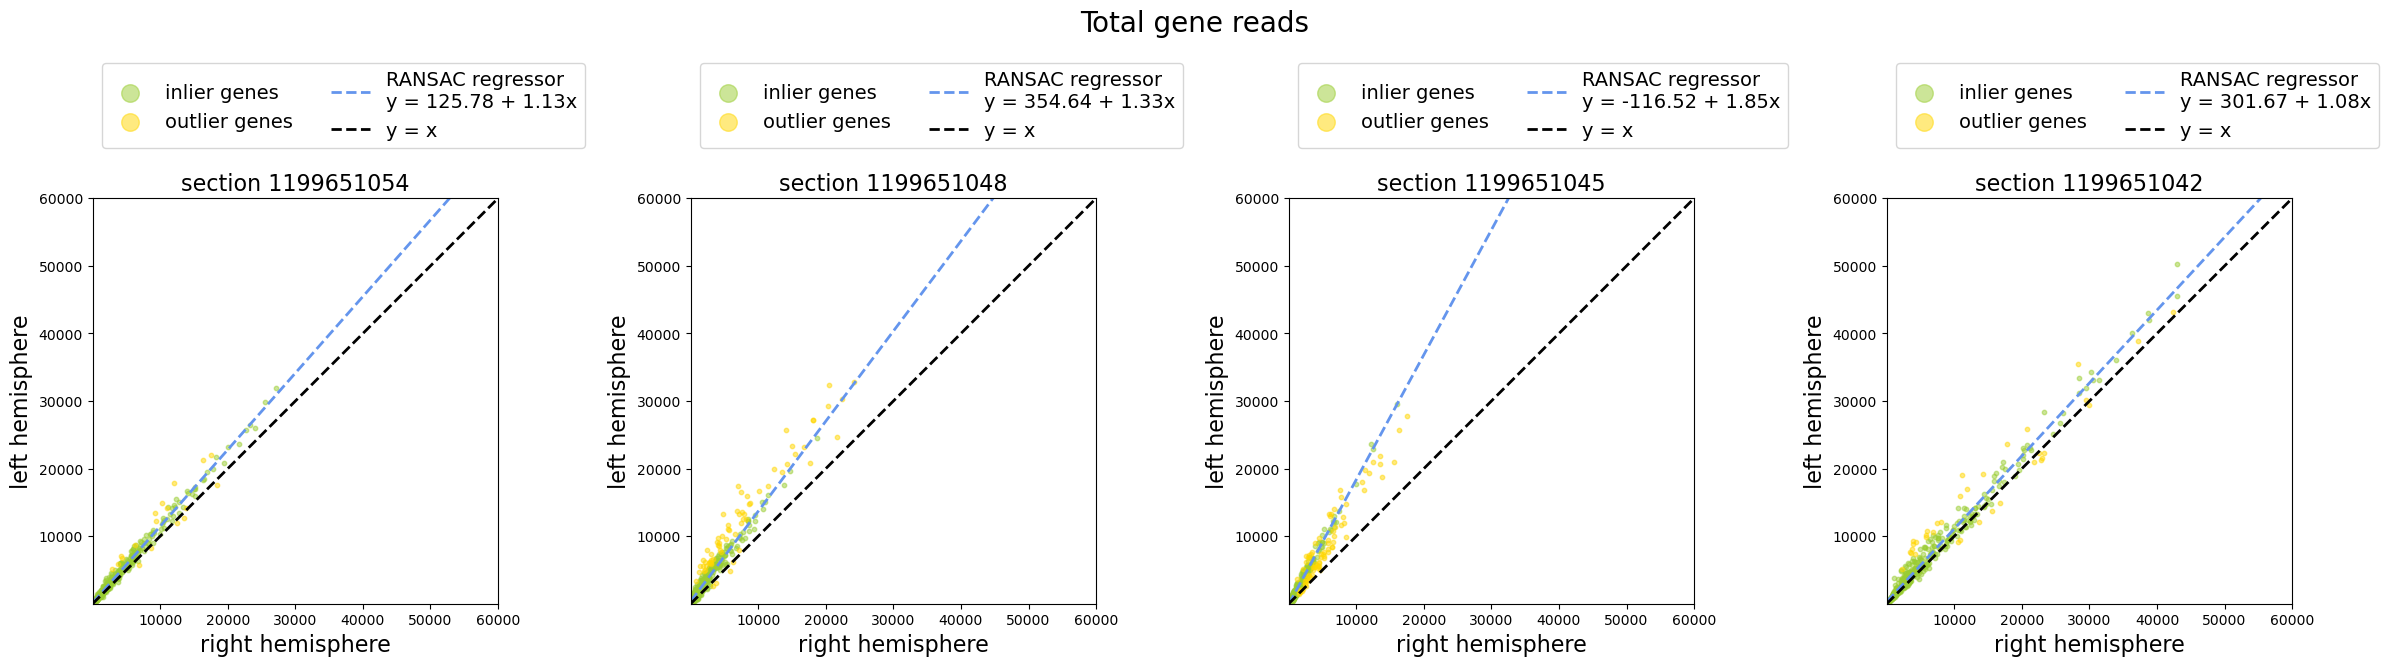

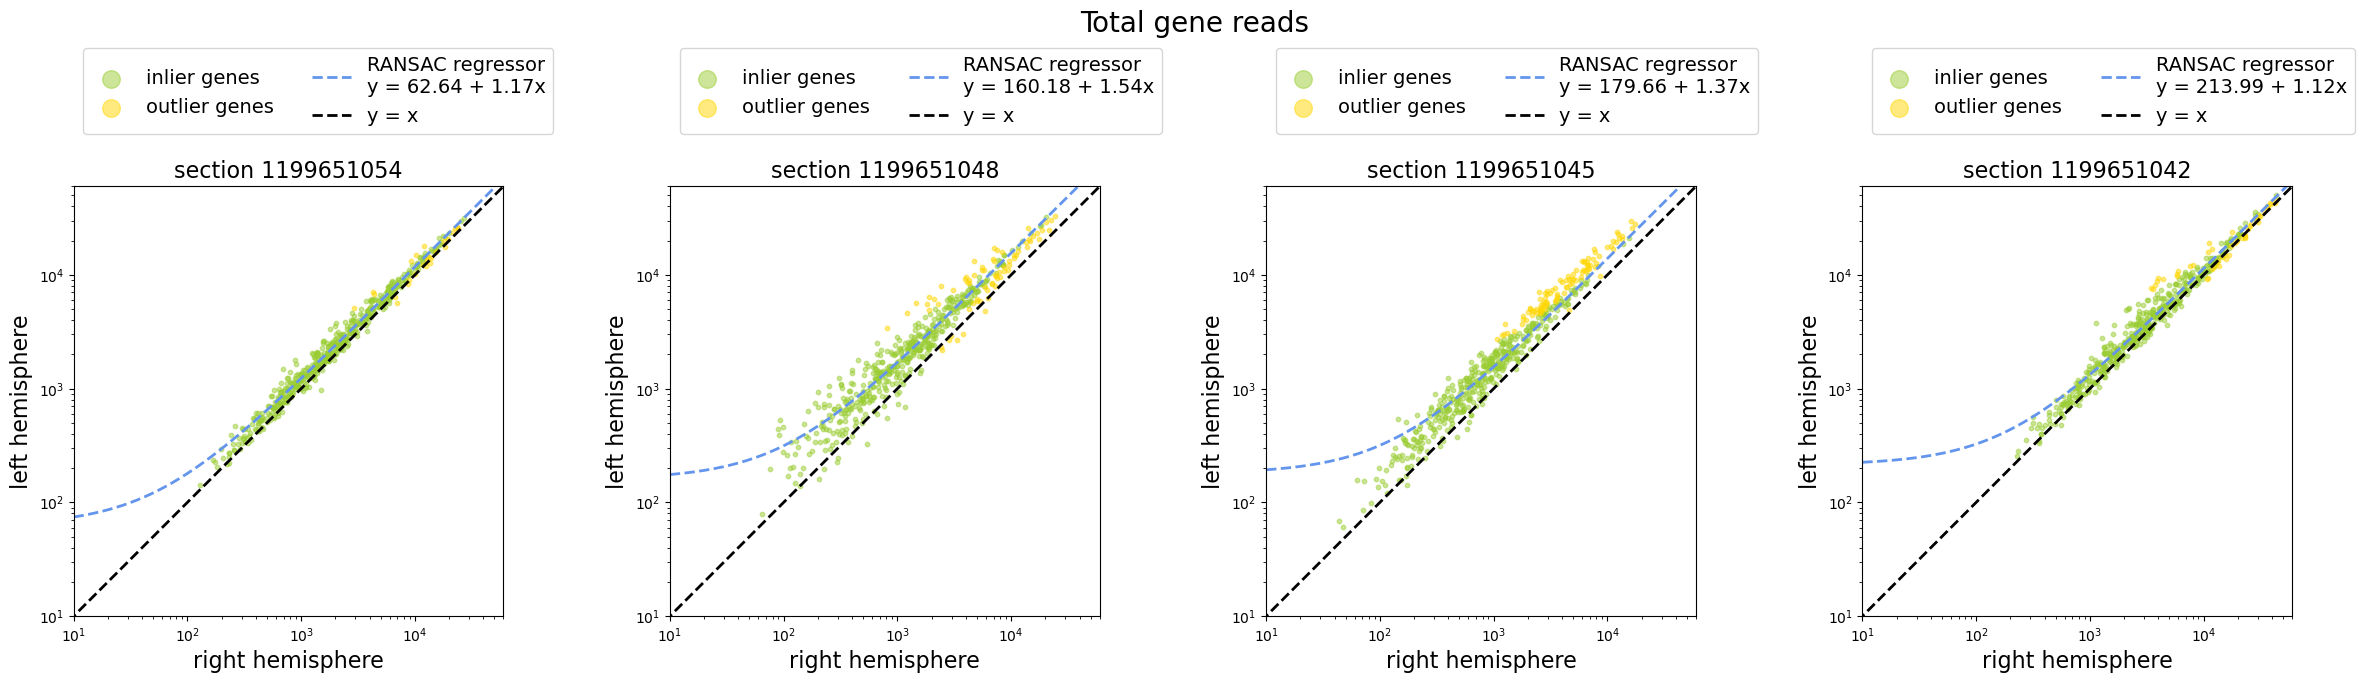

In [18]:
# Total gene reads - RANSAC
fig_tot_reads = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                          property_col_left, property_col_right,
                                          property_name, log_scale=False,
                                          xymin=XY_MIN, xymax=XY_MAX)

fig_tot_reads_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                              property_col_left, property_col_right,
                                              property_name, log_scale=True,
                                              xymin=XY_MIN, xymax=XY_MAX)

### # of gene expressing gene

In [19]:
# Total number of cells expressing each gene
property_col_left = 'n_cells_expr_left'
property_col_right = 'n_cells_expr_right'
property_name = 'Number of cells expressing each gene'
XY_MIN = 80
XY_MAX = 15000

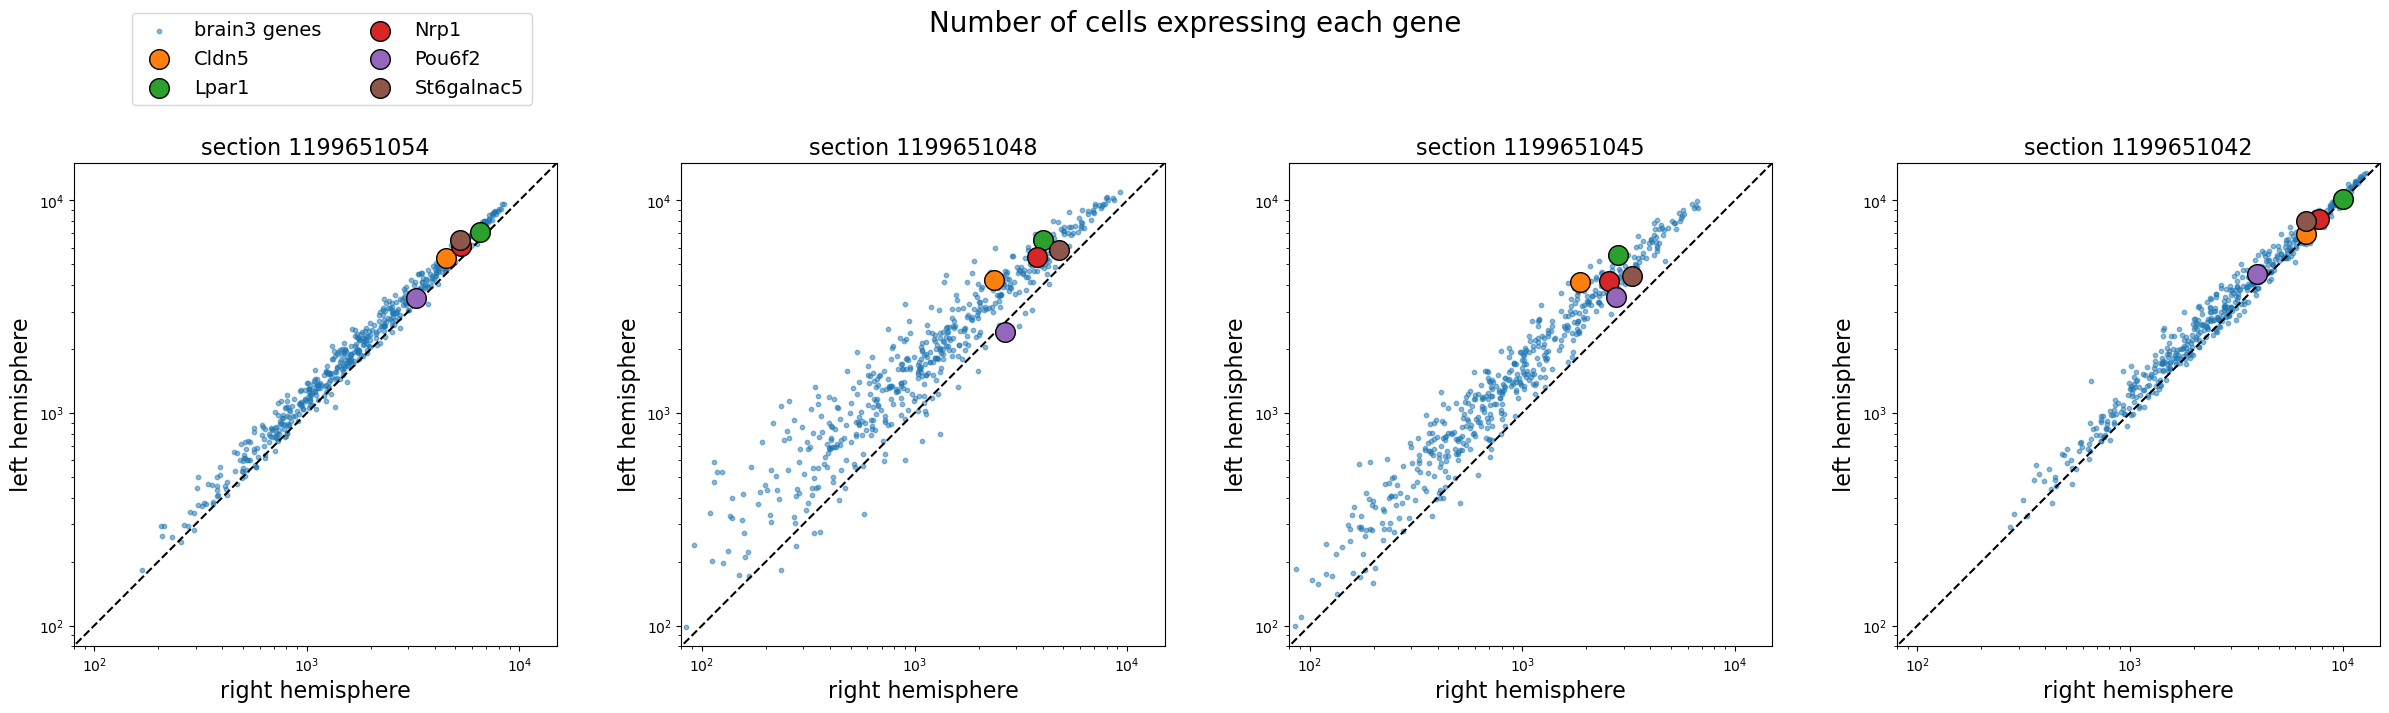

In [20]:
# Total number of cells expressing each gene - with genes highlighted
fig_cells_expr = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                      sec_to_plot, 
                                                      property_col_left, 
                                                      property_col_right,
                                                      property_name, 
                                                      genes_to_highlight=genes_to_highlight,
                                                      xymin=XY_MIN, xymax=XY_MAX)

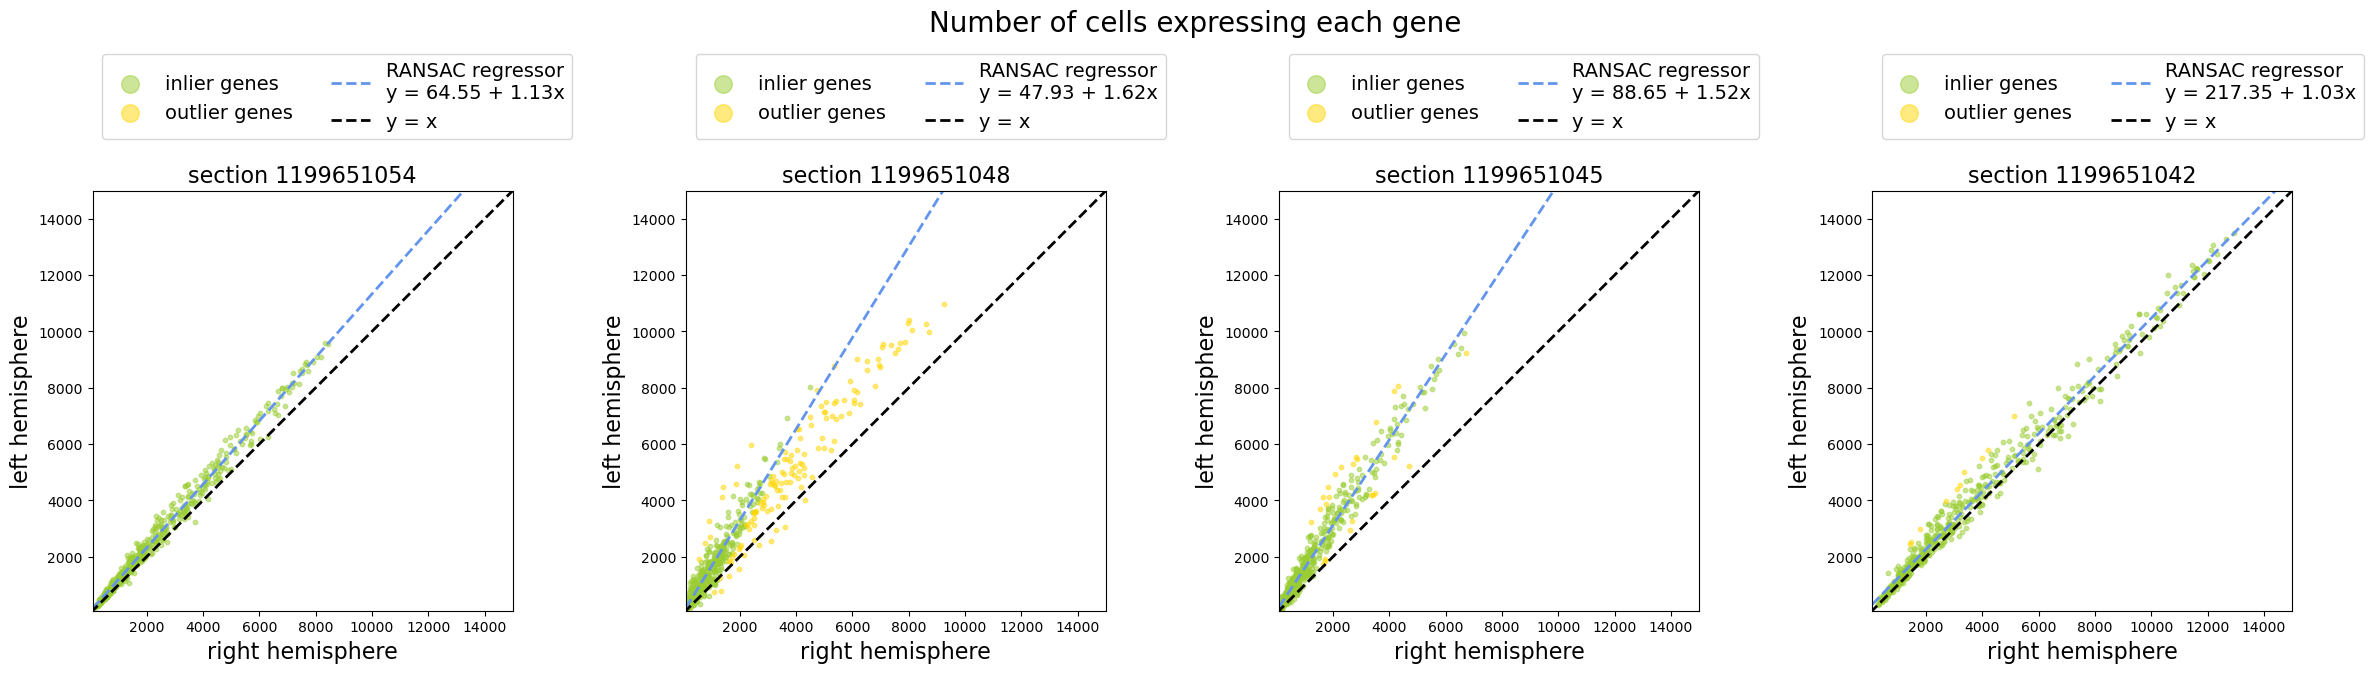

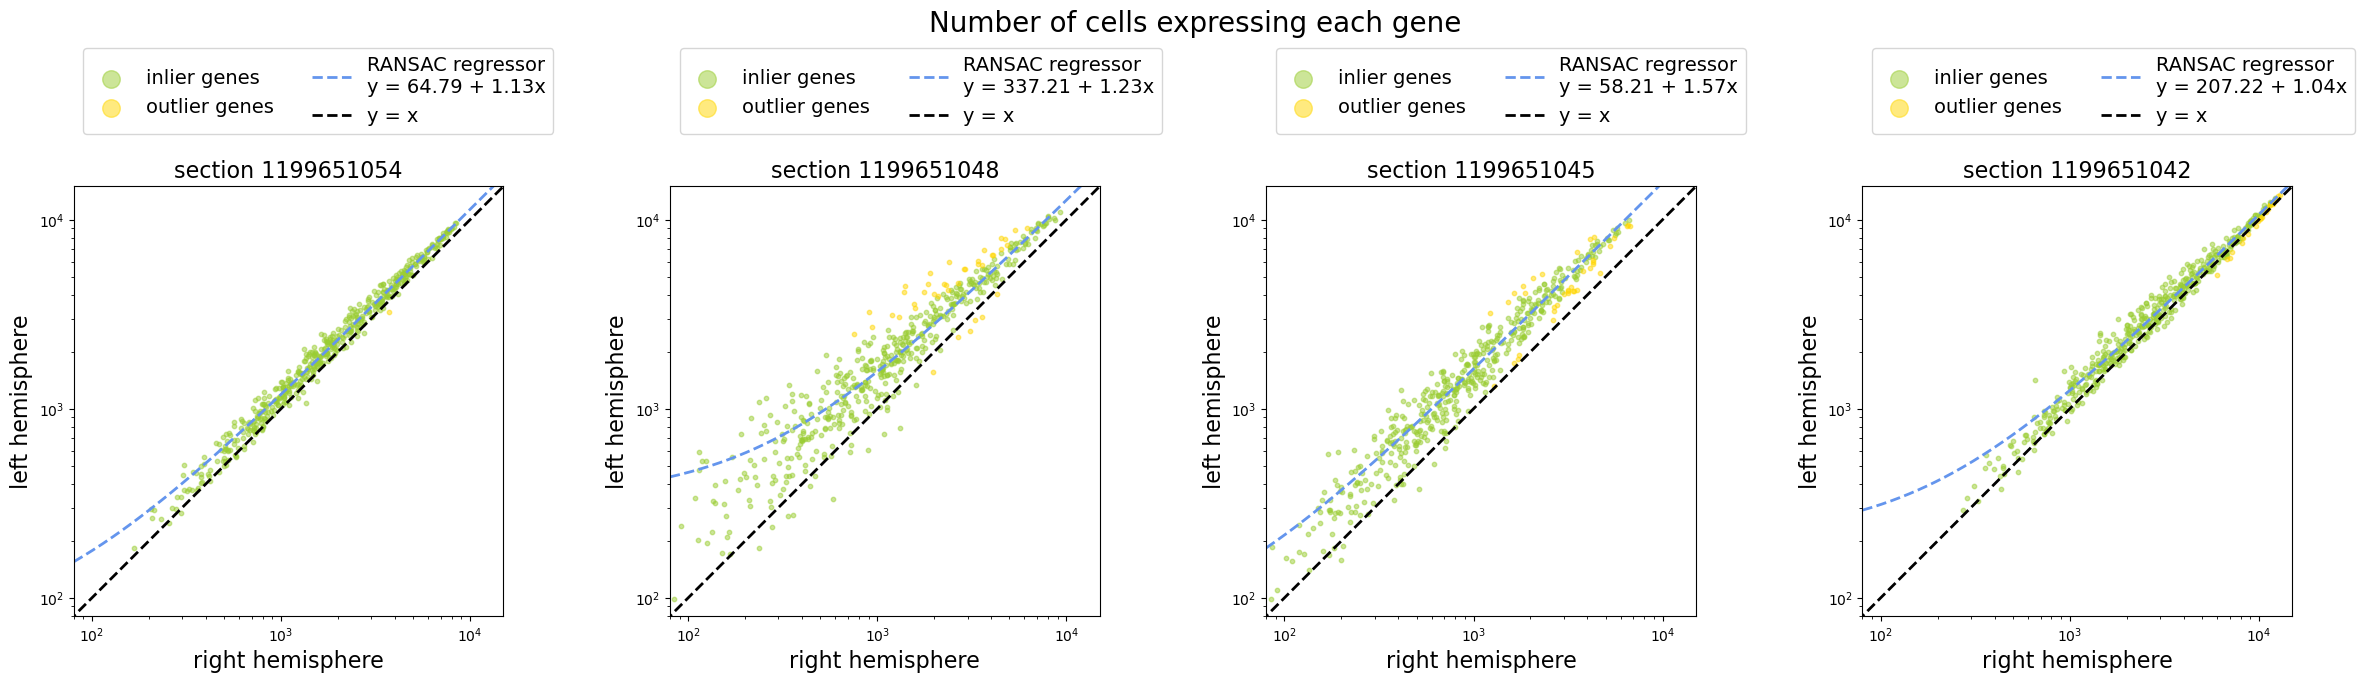

In [21]:
# Total number of cells expressing each gene - RANSAC
fig_cells_expr = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                           property_col_left, property_col_right,
                                           property_name, log_scale=False,
                                           xymin=XY_MIN, xymax=XY_MAX)

fig_cells_expr_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                               property_col_left, property_col_right,
                                               property_name, log_scale=True,
                                               xymin=XY_MIN, xymax=XY_MAX)

### fraction of cell expressing each gene

In [22]:
# Fraction of cells expressing each gene
property_col_left = 'frac_cells_expr_left'
property_col_right = 'frac_cells_expr_right'
property_name = 'Fraction of cells expressing each gene'
XY_MIN = 0
XY_MAX = 1

<ipython-input-13-800dd2b541d0>:61: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xymin, xymax)
<ipython-input-13-800dd2b541d0>:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(xymin, xymax)


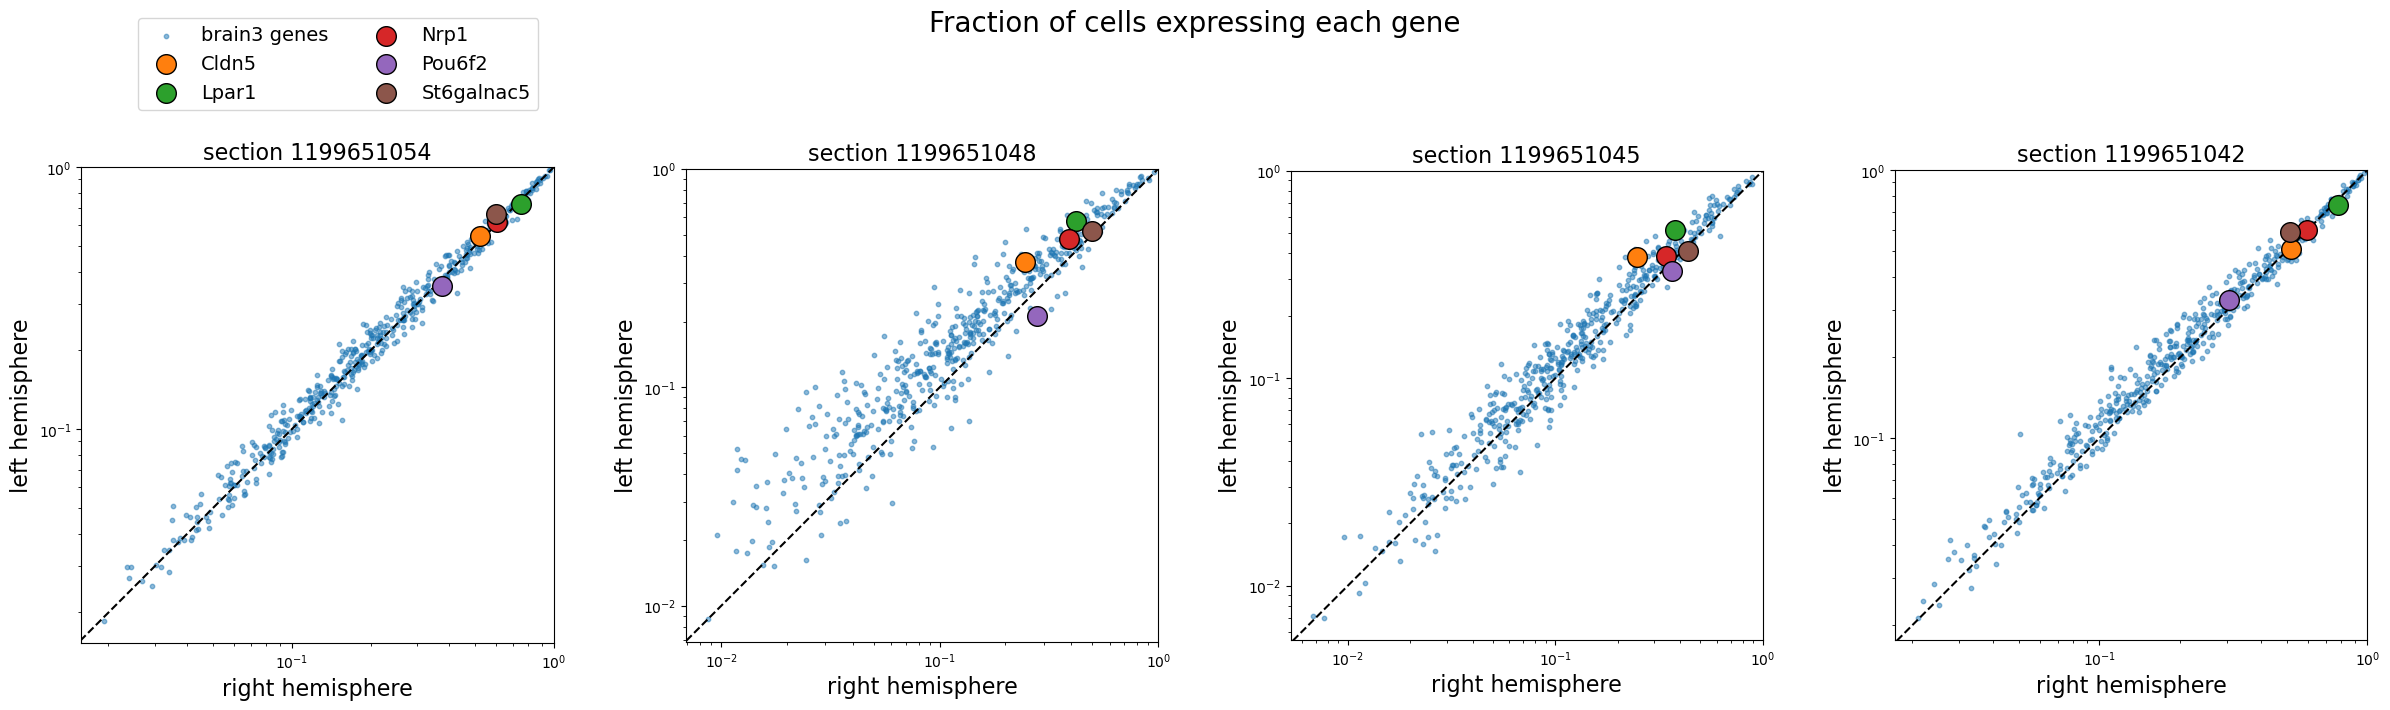

In [23]:
# Fraction of cells expressing each gene - with genes highlighted
fig_frac_expr = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymin=XY_MIN, xymax=XY_MAX)

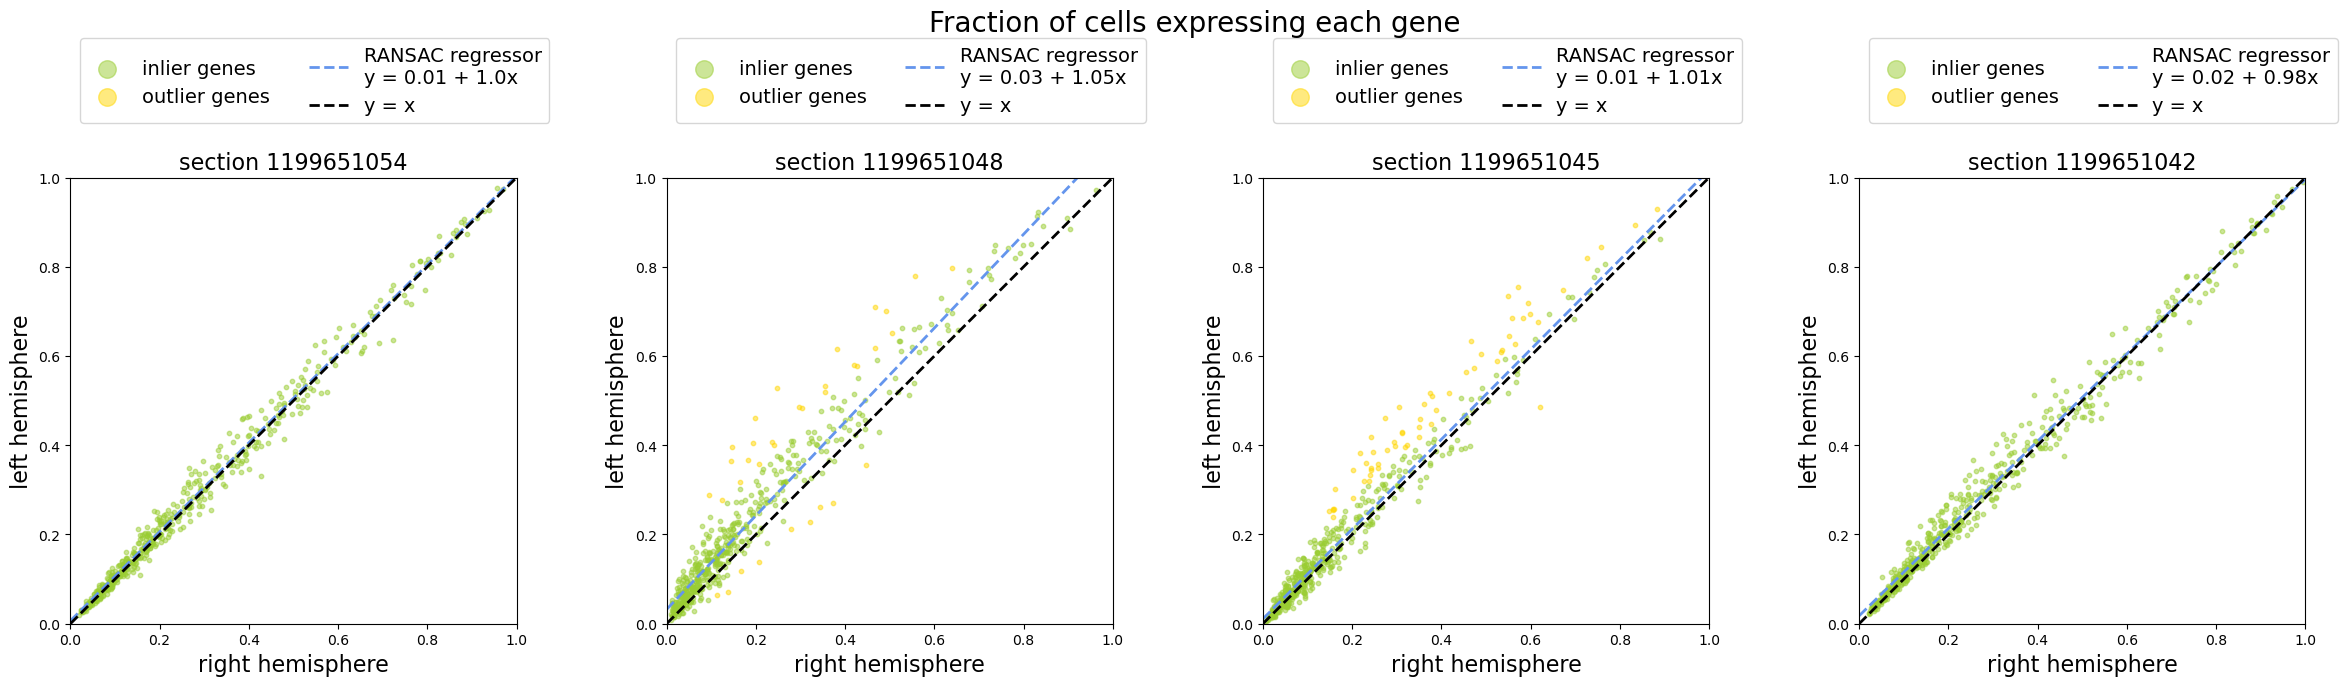

<ipython-input-14-a6eb362c0434>:93: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:94: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:93: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:94: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:93: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:94: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(xymin, xymax)
<ipython-input-14-a6eb362c0434>:93: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be i

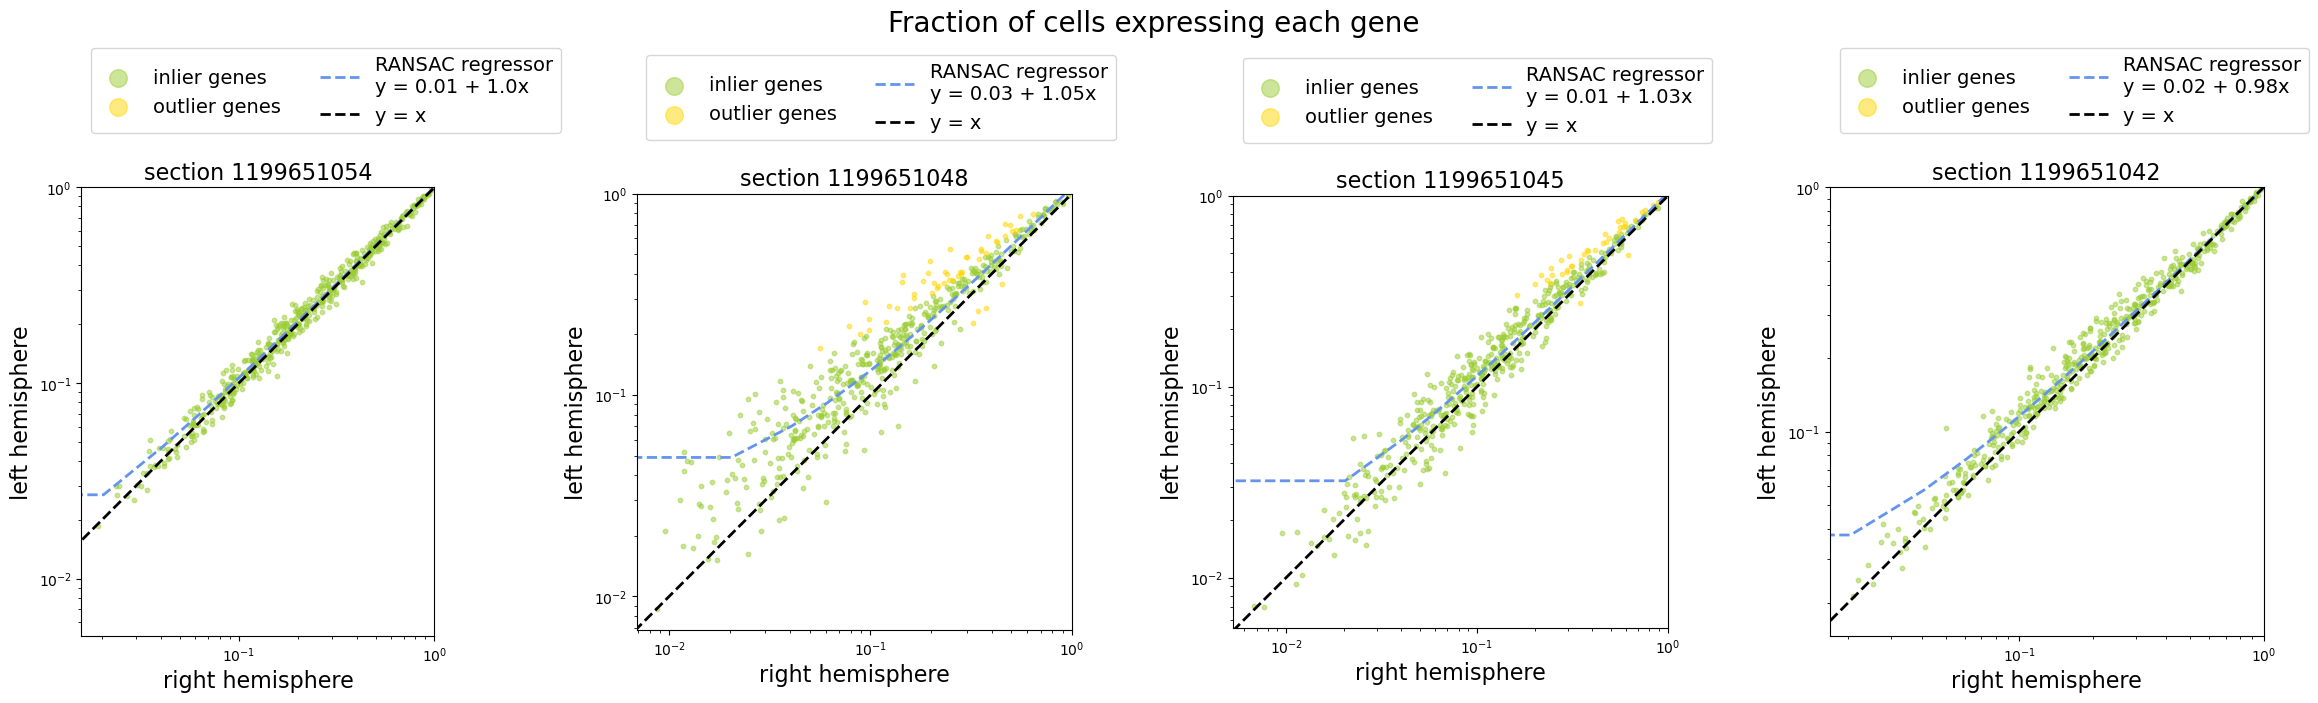

In [24]:
# Fraction of cells expressing each gene - RANSAC
fig_frac_expr = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                           property_col_left, property_col_right,
                                           property_name, log_scale=False,
                                           xymin=XY_MIN, xymax=XY_MAX)

fig_frac_expr_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                               property_col_left, property_col_right,
                                               property_name, log_scale=True,
                                               xymin=XY_MIN, xymax=XY_MAX)

### 99th percentile gene expression, normalized per cell

In [25]:
# 99th percentile gene expression, normalized per cell
property_col_left = '99pct_left_per_cell'
property_col_right = '99pct_right_per_cell'
property_name = '99th percentile expression per cell'
XY_MIN = 0.00004
XY_MAX = 0.0007

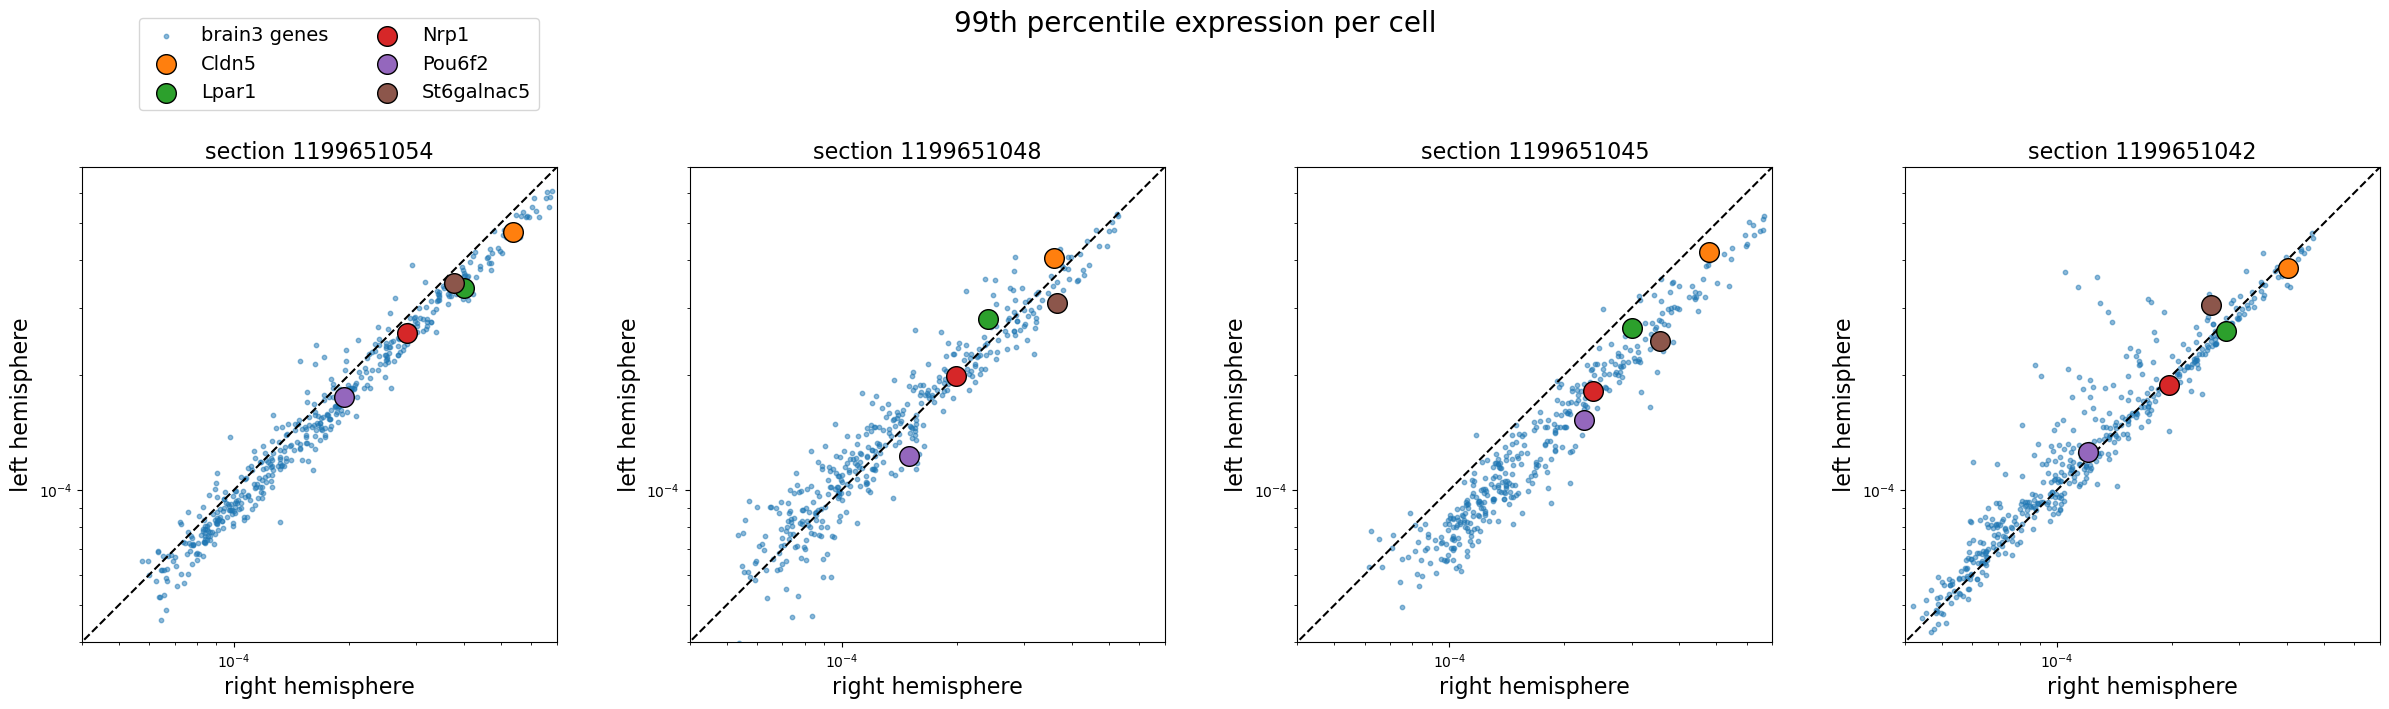

In [26]:
# 99th pct expression - with genes highlighted
fig_99pct = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                 sec_to_plot, 
                                                 property_col_left, 
                                                 property_col_right,
                                                 property_name, 
                                                 genes_to_highlight=genes_to_highlight,
                                                 xymin=XY_MIN, xymax=XY_MAX)

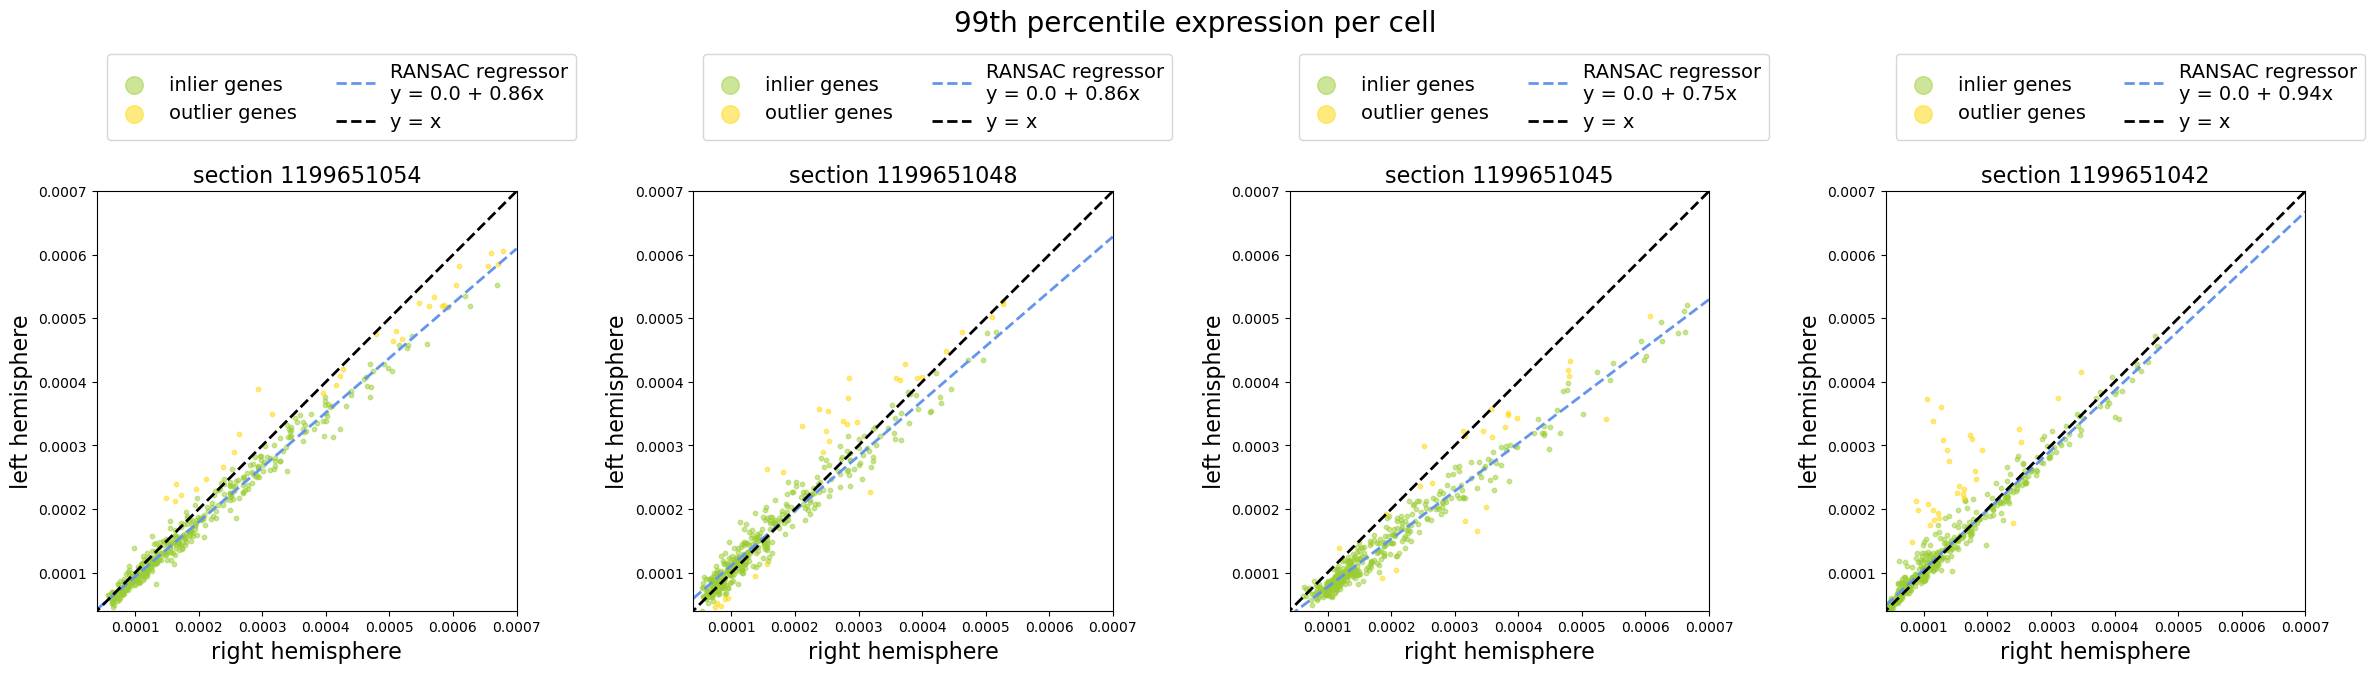

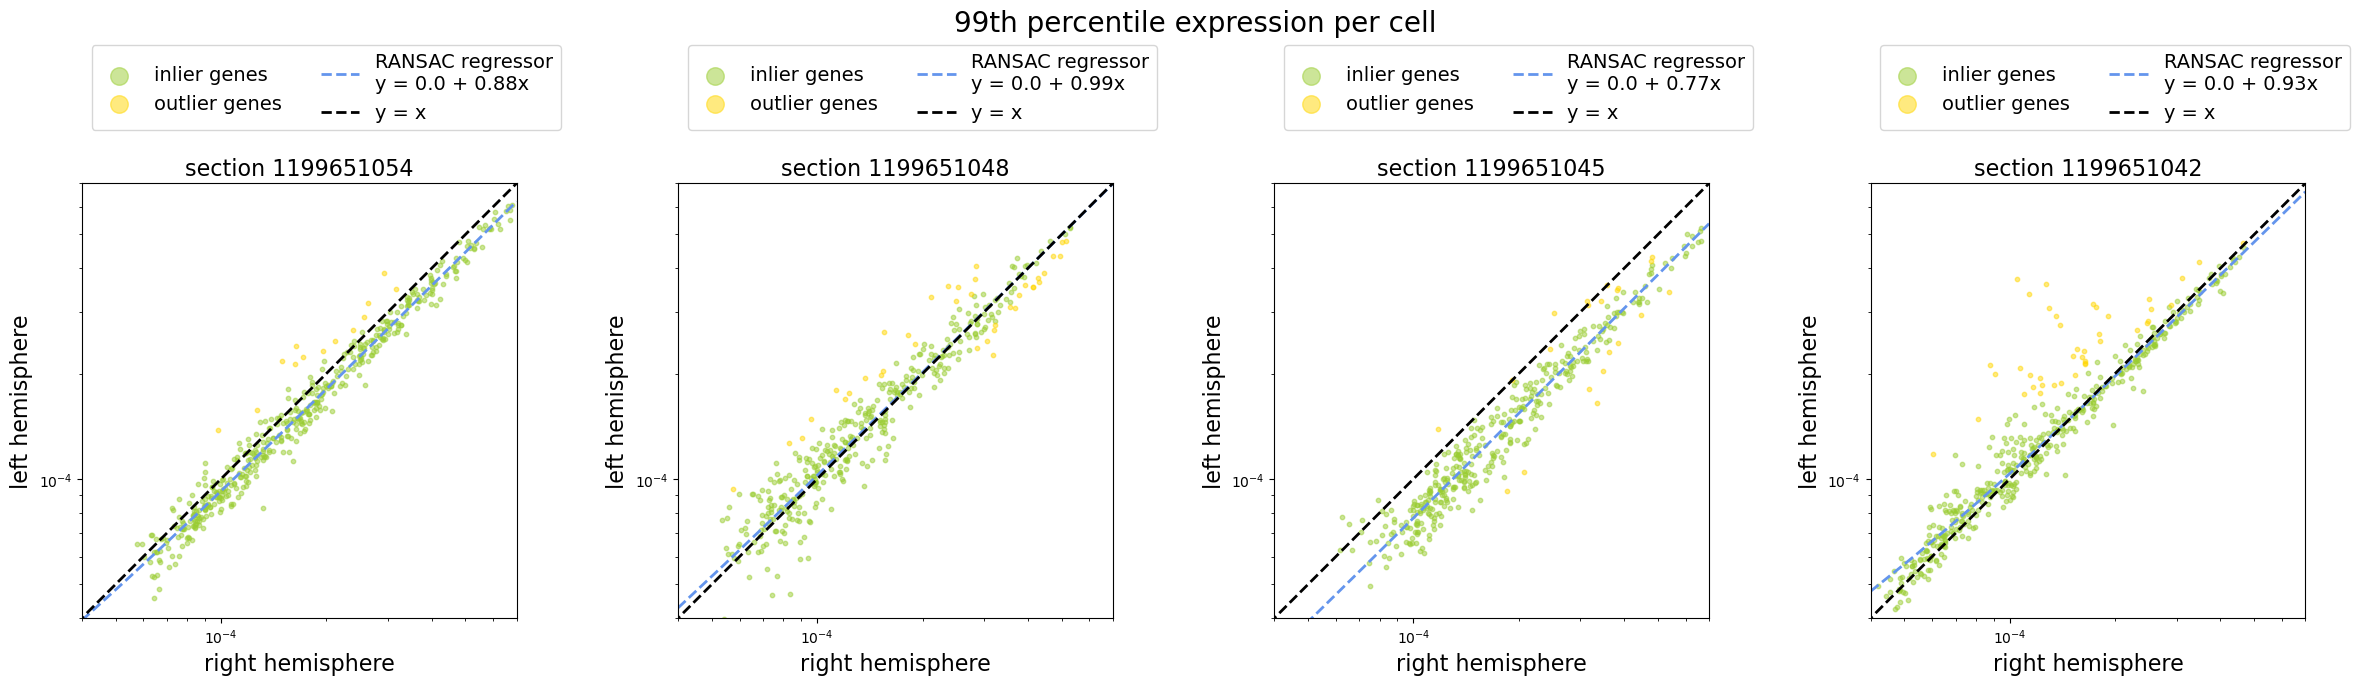

In [27]:
# 99th pct expression - RANSAC
fig_99pct_ransac = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                            property_col_left, property_col_right,
                                            property_name, log_scale=False,
                                            xymin=XY_MIN, xymax=XY_MAX)

fig_99pct_ransac_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                                 property_col_left, property_col_right,
                                                 property_name, log_scale=True,
                                                 xymin=XY_MIN, xymax=XY_MAX)

### 99th percentile gene expression, not normalized

In [28]:
# 99th percentile gene expression, not normalized
property_col_left = '99pct_left'
property_col_right = '99pct_right'
property_name = '99th percentile expression'
XY_MIN = 0.4
XY_MAX = 10

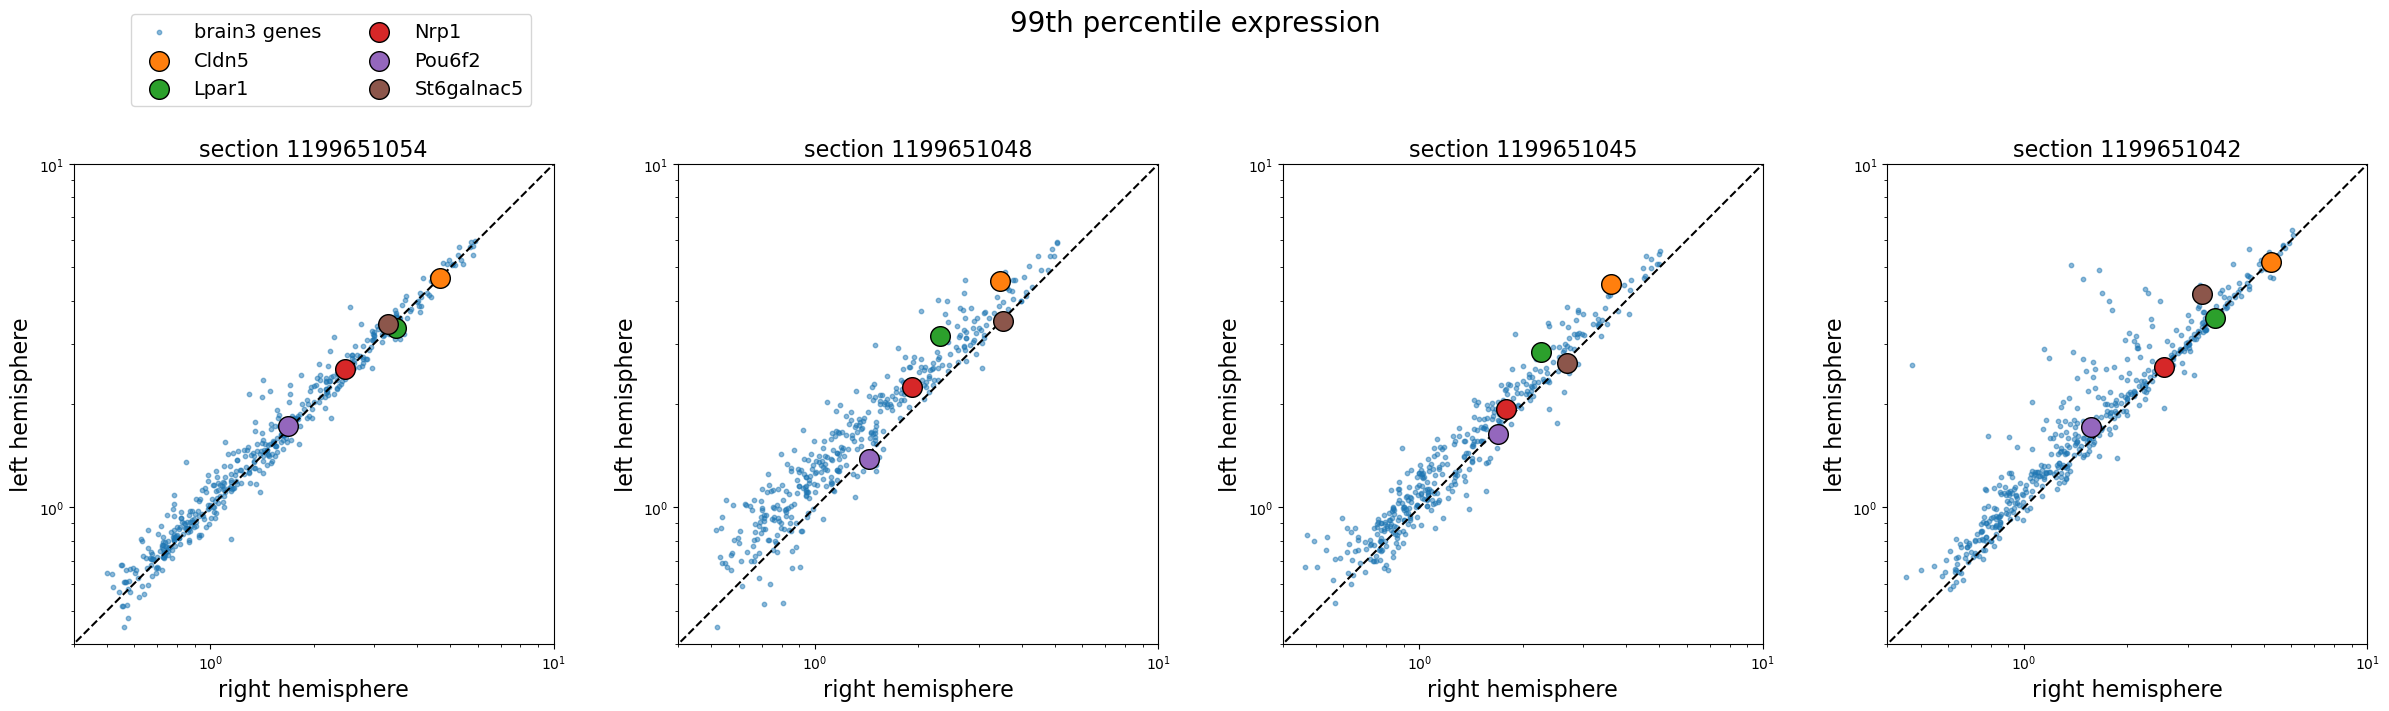

In [29]:
# 99th percentile gene expression, not normalized - with genes highlighted
fig_99pct = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                      sec_to_plot, 
                                                      property_col_left, 
                                                      property_col_right,
                                                      property_name, 
                                                      genes_to_highlight=genes_to_highlight,
                                                      xymin=XY_MIN, xymax=XY_MAX)

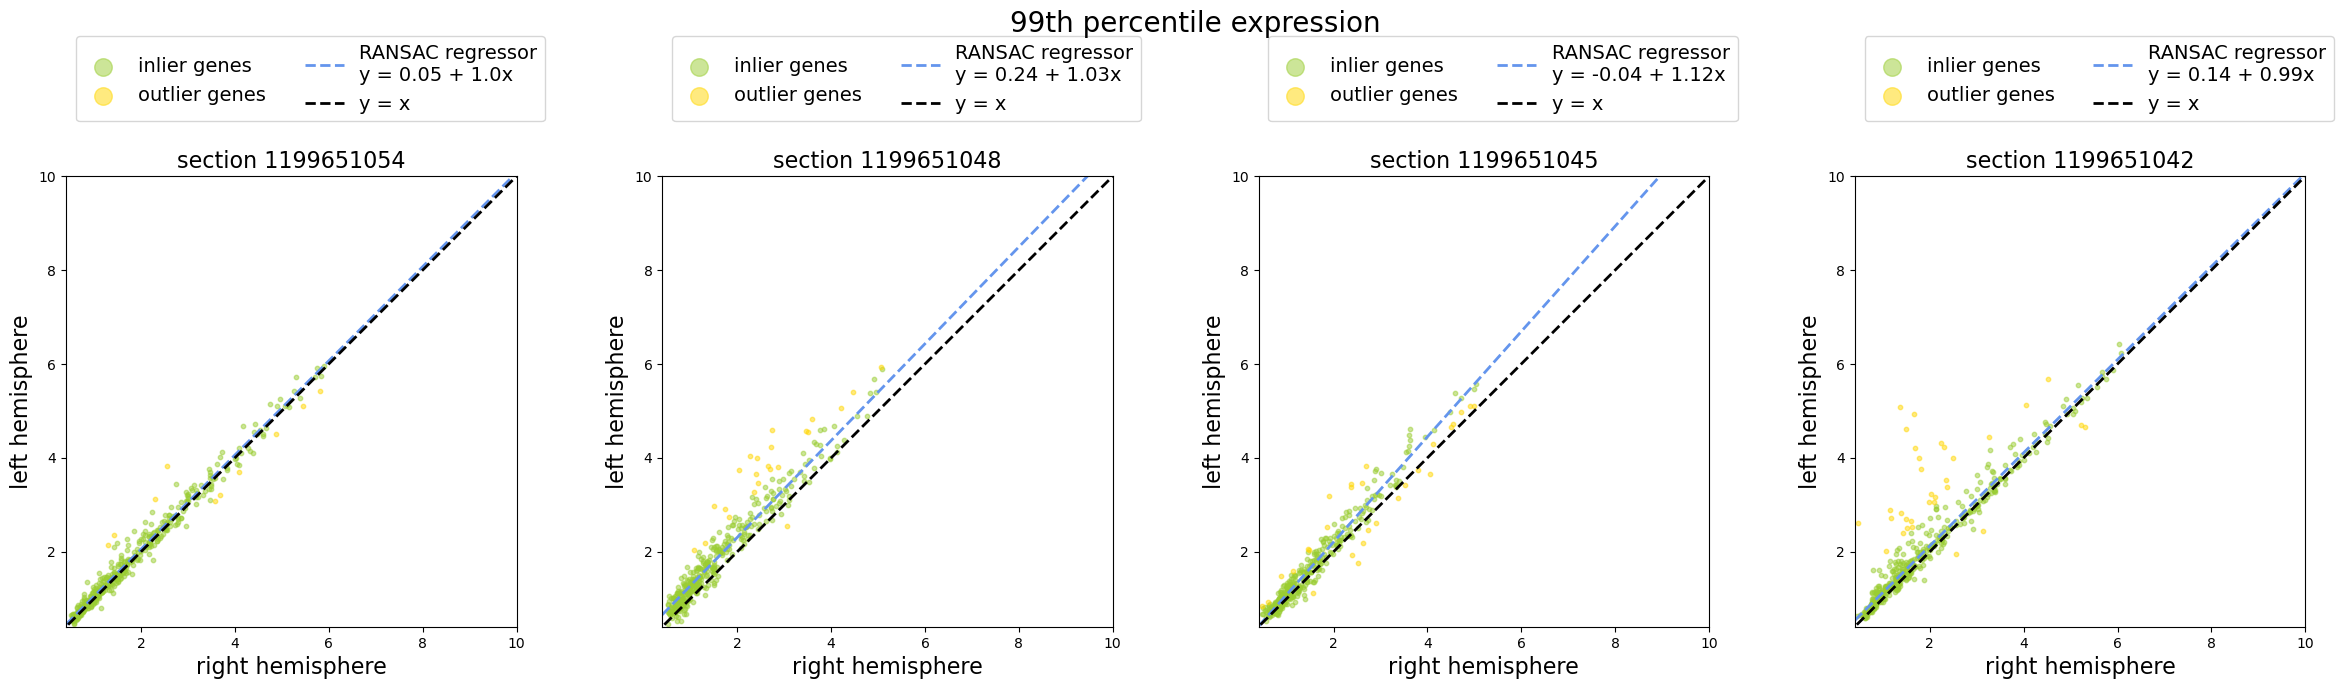

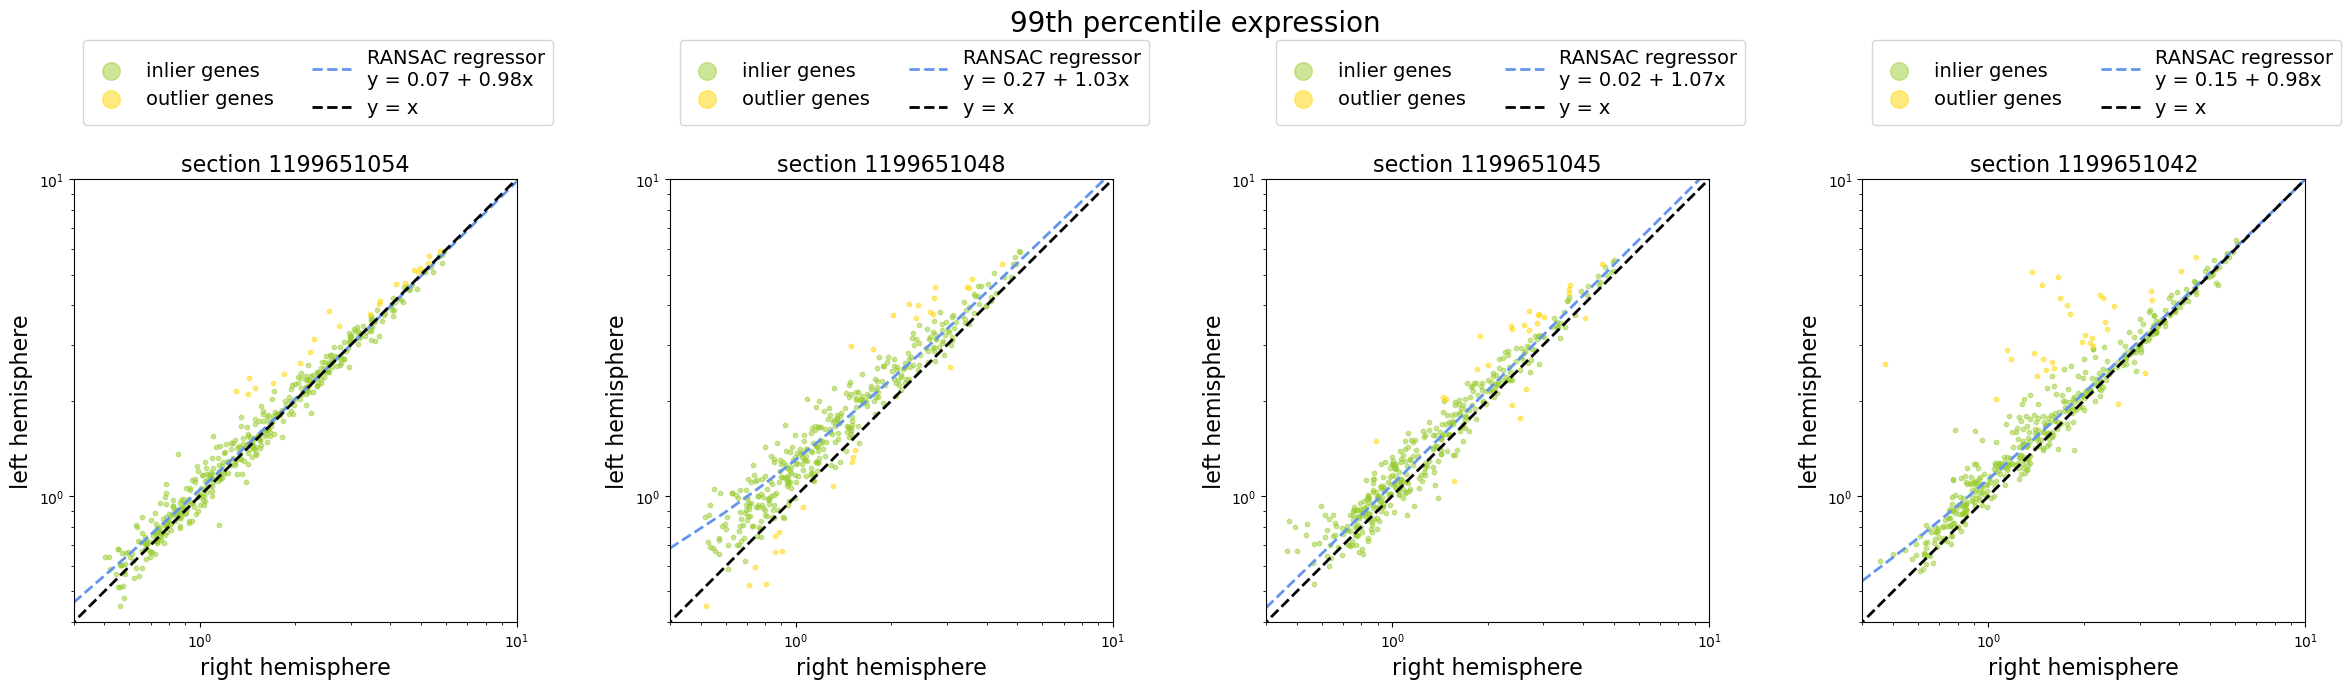

In [30]:
# 99th pct expression, not normalized - RANSAC
fig_99pct_ransac = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                            property_col_left, property_col_right,
                                            property_name, log_scale=False,
                                            xymin=XY_MIN, xymax=XY_MAX)

fig_99pct_ransac_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                                 property_col_left, property_col_right,
                                                 property_name, log_scale=True,
                                                 xymin=XY_MIN, xymax=XY_MAX)

### Mean gene expression, not normalized

In [31]:
# Mean gene expression, not normalized
property_col_left = 'mean_left'
property_col_right = 'mean_right'
property_name = 'Mean expression'
XY_MIN = 0.005
XY_MAX = 5

In [32]:
# np.linspace(XY_MIN,XY_MAX)

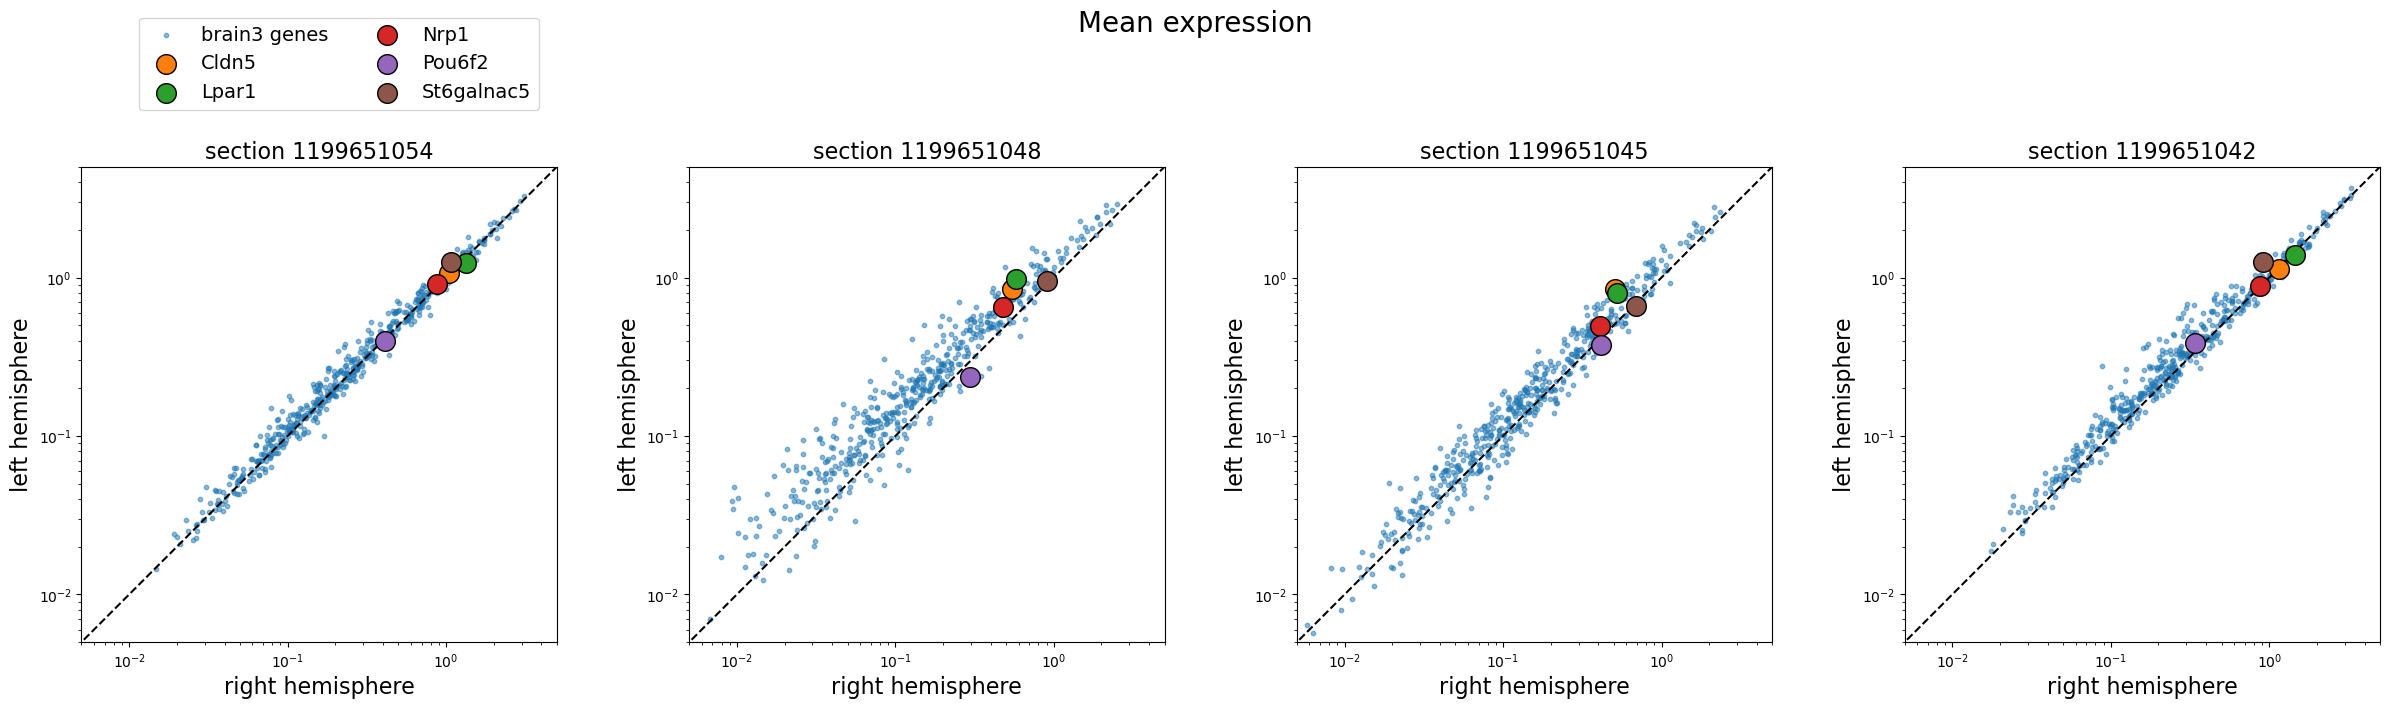

In [33]:
# Mean gene expression, not normalized - genes highlighted
fig_mean = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                sec_to_plot, 
                                                property_col_left, 
                                                property_col_right,
                                                property_name, 
                                                genes_to_highlight=genes_to_highlight,
                                                xymin=XY_MIN, xymax=XY_MAX)

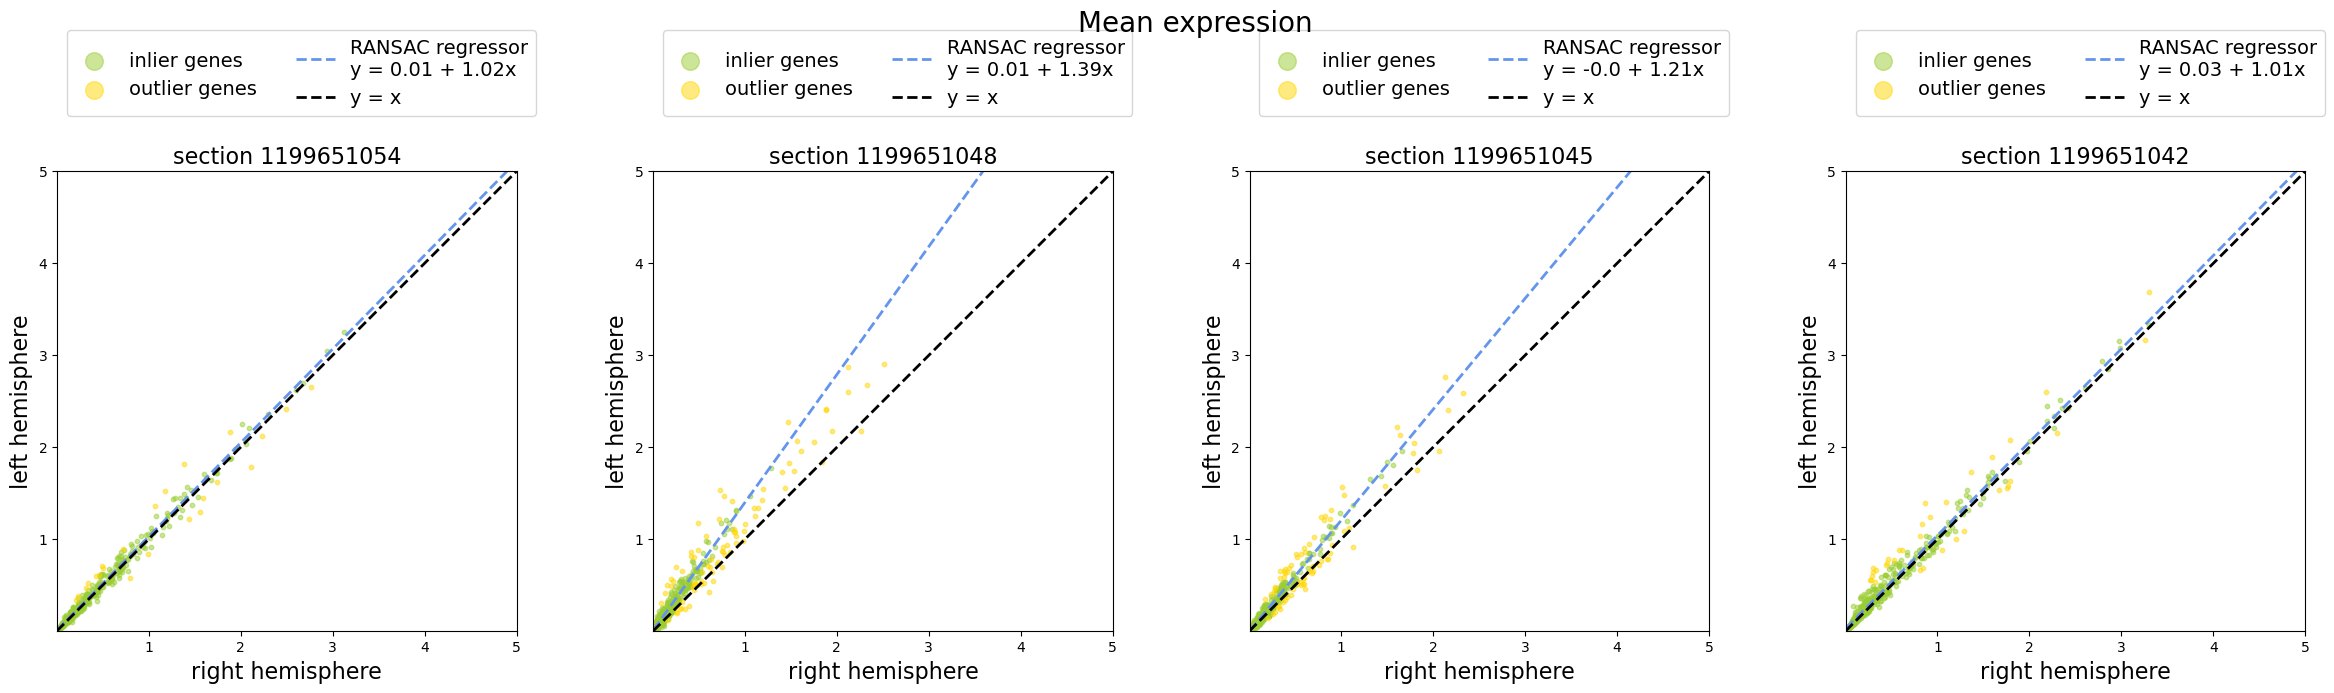

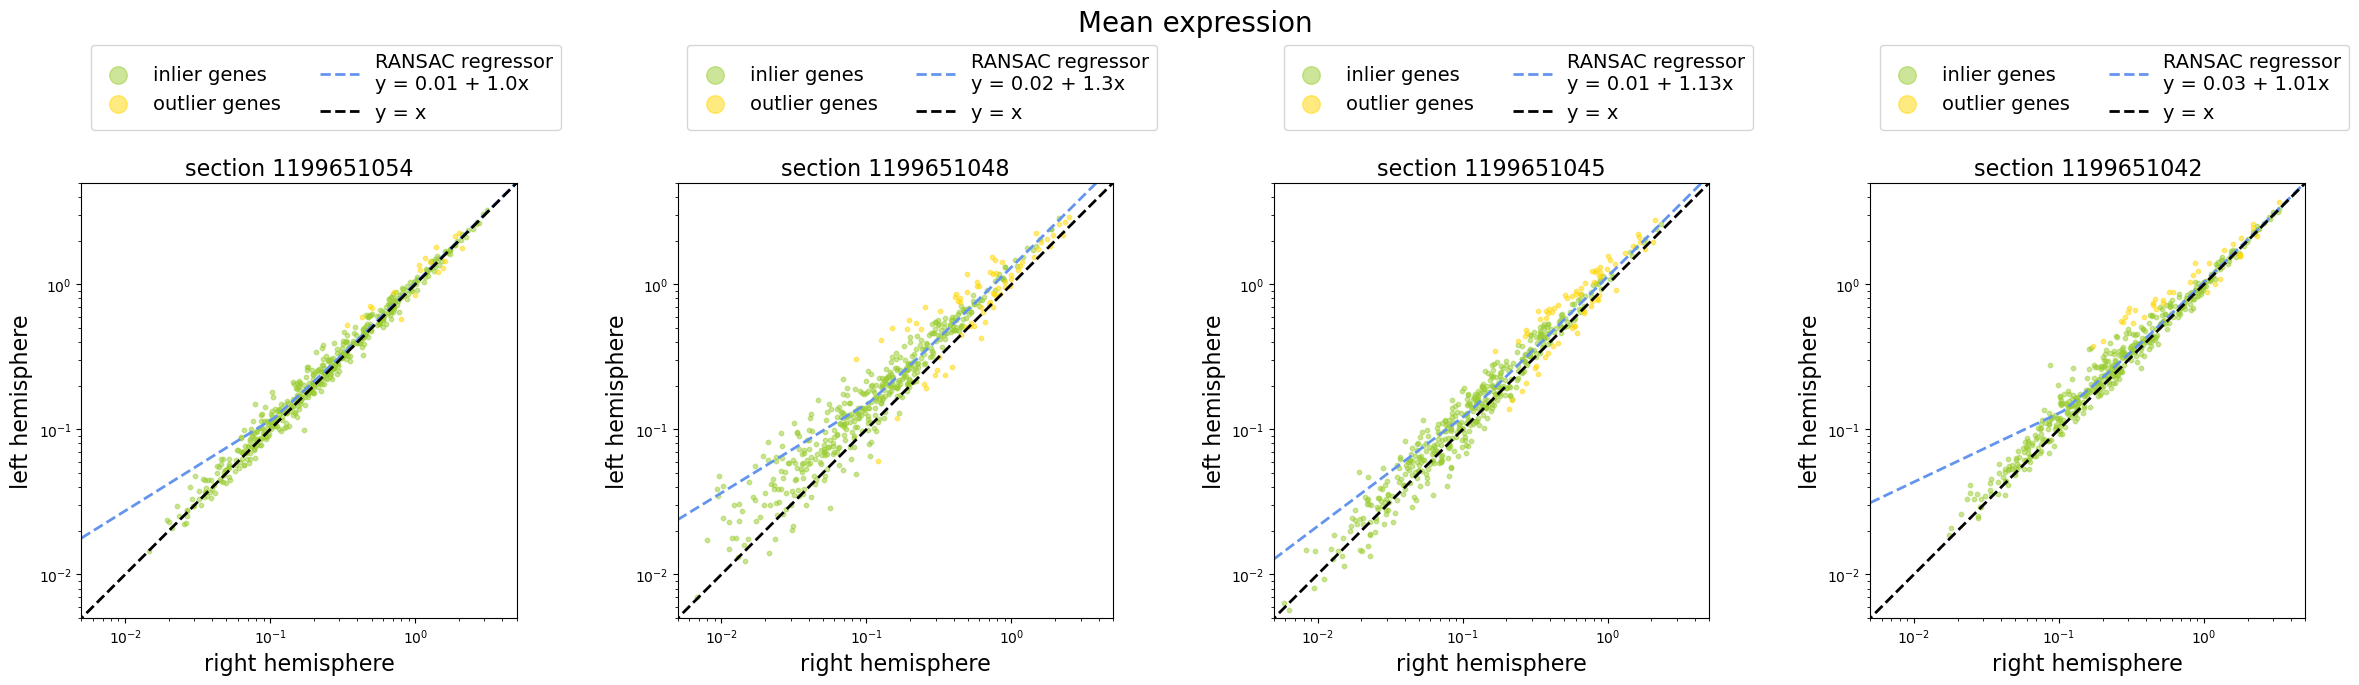

In [34]:
# Mean gene expression, not normalized - RANSAC
fig_mean_ransac = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                            property_col_left, property_col_right,
                                            property_name, log_scale=False,
                                            xymin=XY_MIN, xymax=XY_MAX)

fig_mean_ransac_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                                property_col_left, property_col_right,
                                                property_name, log_scale=True,
                                                xymin=XY_MIN, xymax=XY_MAX)

### mean gene expression, normalized per cell

In [35]:
# Mean gene expression, normalized per cell
property_col_left = 'mean_left_per_cell'
property_col_right = 'mean_right_per_cell'
property_name = 'Mean expression per cell'
XY_MIN = 0.000001
XY_MAX = 0.0005

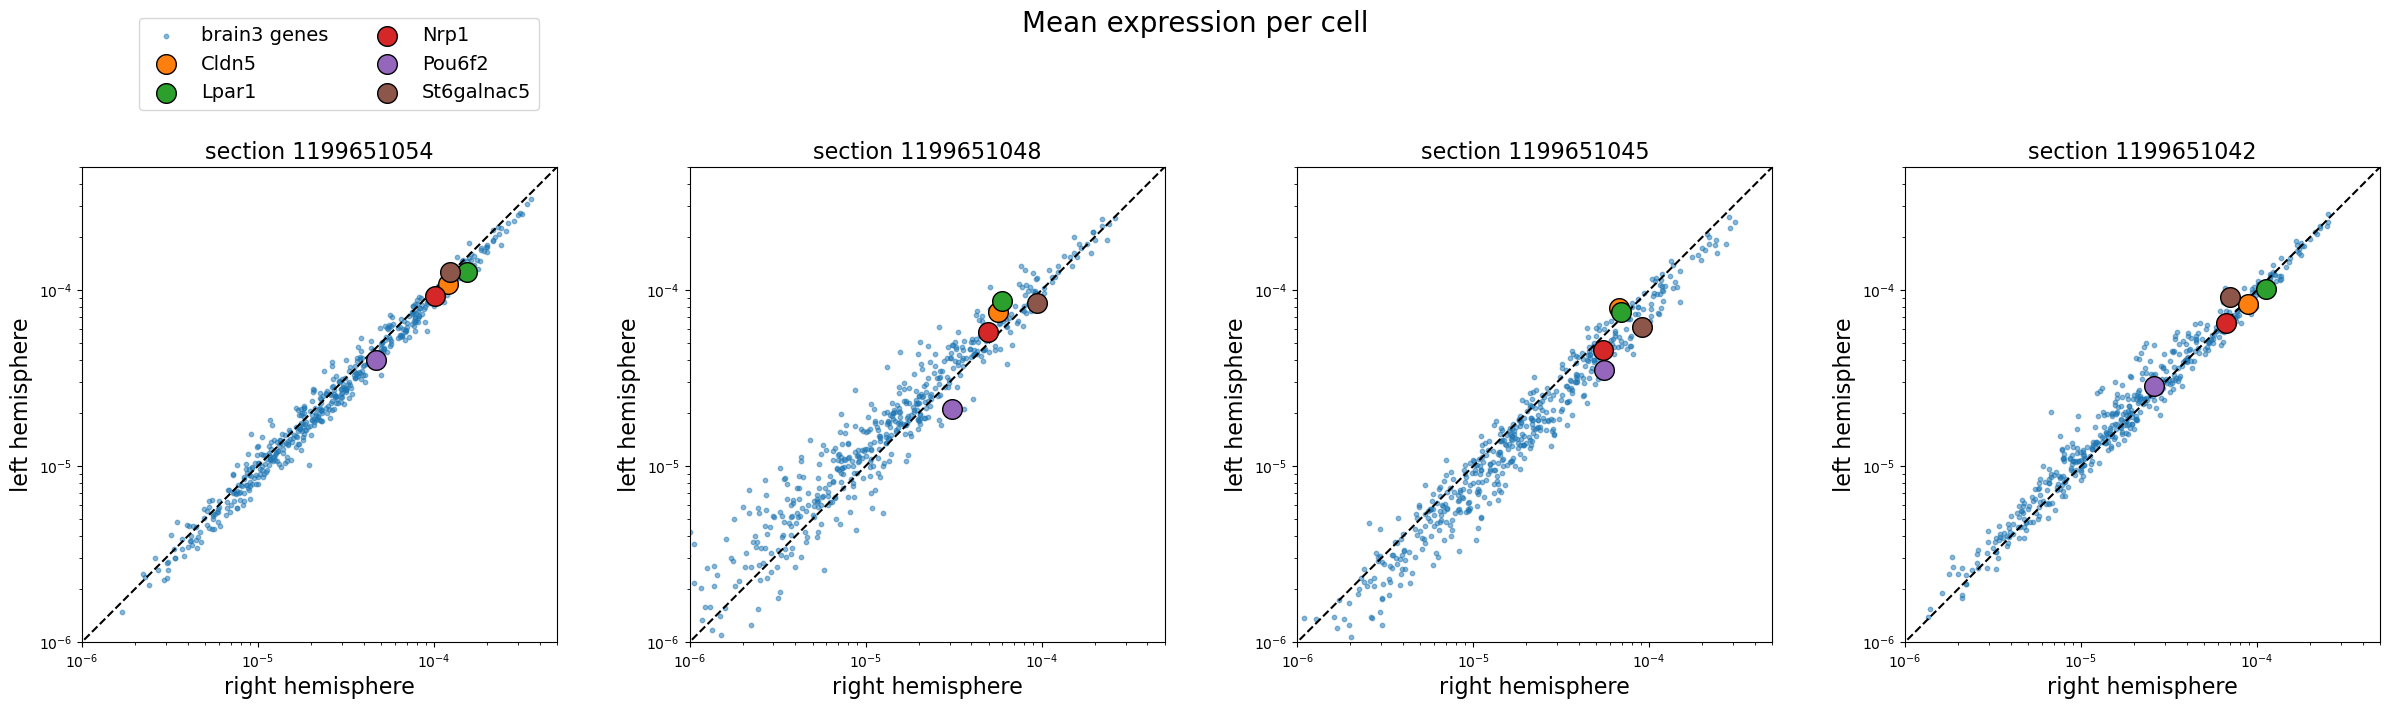

In [36]:
# Mean gene expression, normalized per cell - genes higlighted
fig_mean_norm = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymin=XY_MIN, xymax=XY_MAX)

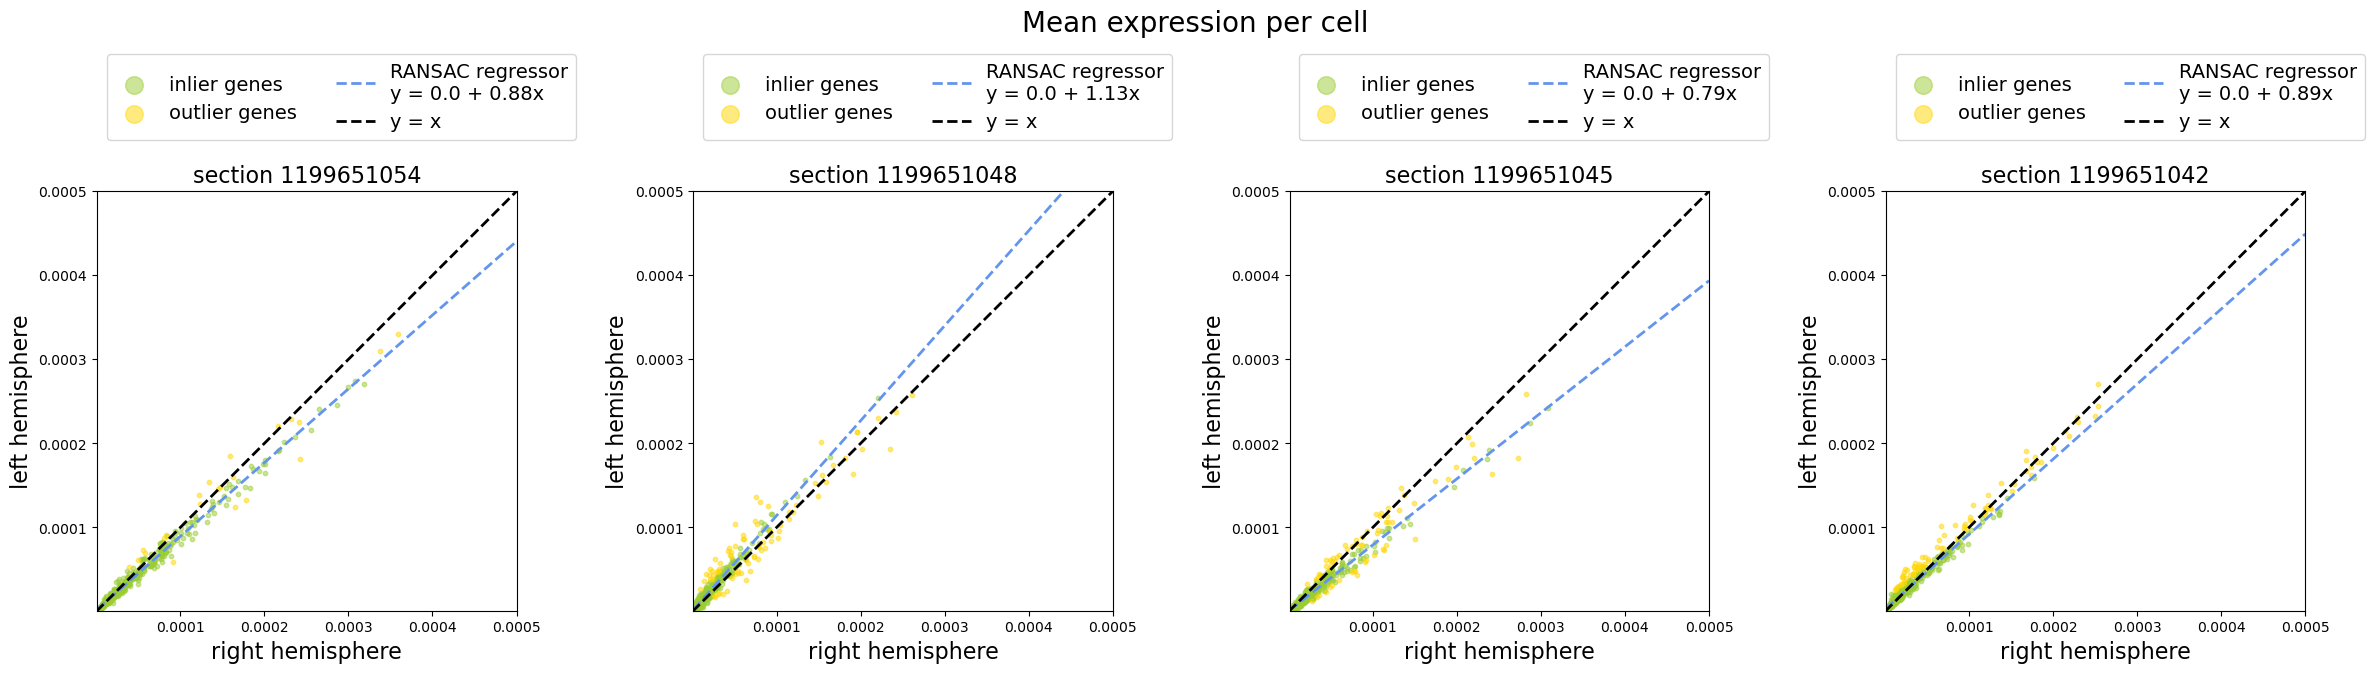

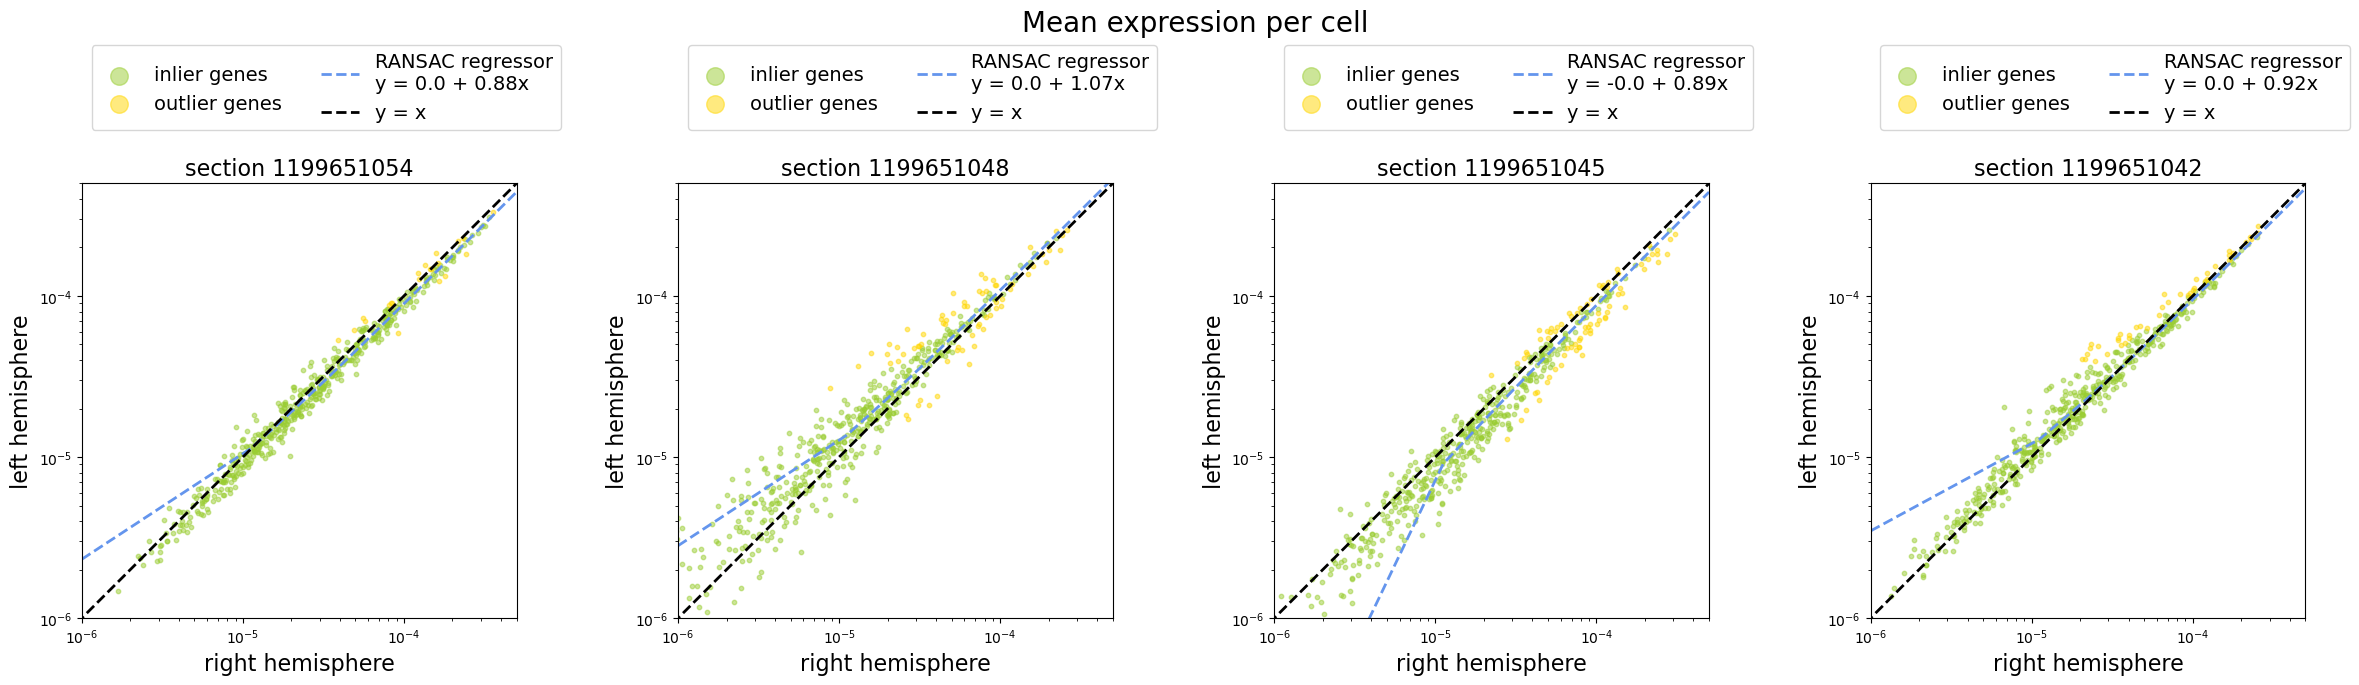

In [37]:
# Mean gene expression, normalized - RANSAC
fig_mean_norm_ransac = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                                property_col_left, property_col_right,
                                                property_name, log_scale=False,
                                                xymin=XY_MIN, xymax=XY_MAX)

fig_mean_norm_ransac_log = plot_left_vs_right_ransac(section_LR_properties, sec_to_plot, 
                                                    property_col_left, property_col_right,
                                                    property_name, log_scale=True,
                                                    xymin=XY_MIN, xymax=XY_MAX)

## Gene expression distributions

Should we screen each gene for these asymmetries to see which ones are bad/worst?

Could run K-S test for each gene to compare it's expression distribution between L & R hemispheres, then flag any that are “too” different by some metric (what metric?)

In [38]:
ks_test_pval = []
for gene in genes:
    ks_test_pval.append(stats.ks_2samp(right_hemi_ad[:, gene].X.A.flatten(), 
                                       left_hemi_ad[:, gene].X.A.flatten(),
                                       alternative='two-sided',
                                       method='asymp')[1])

In [39]:
# calculate mean expression in left hemisphere for each gene
mean_left = np.mean(left_hemi_ad.X.A, axis=0)

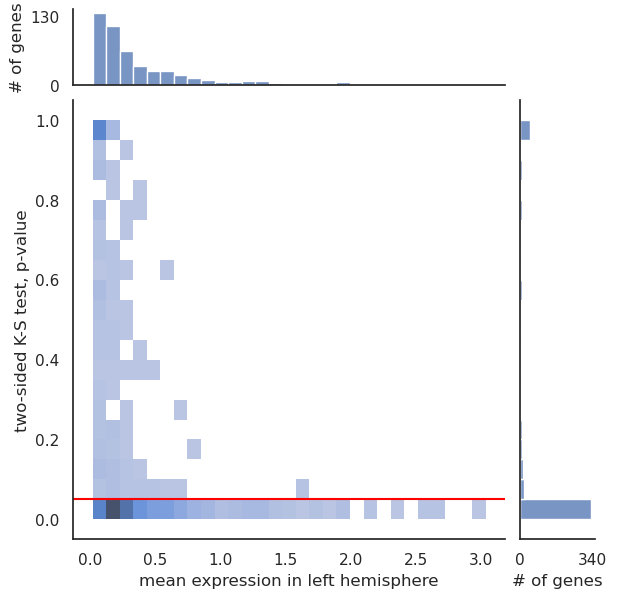

In [40]:
sns.set(rc={"figure.figsize":(12, 4)}) #width=3, #height=4
sns.set_style('white')
jp = sns.jointplot(x=mean_left, y=ks_test_pval, kind='hist', marginal_ticks=True)
jp.ax_marg_x.set_yticks([0,130])
jp.ax_marg_x.set_ylabel('# of genes')
jp.ax_marg_y.set_xticks([0,340])
jp.ax_marg_y.set_xlabel('# of genes')
plt.axhline(y=0.05, color='red')
plt.xlabel('mean expression in left hemisphere')
plt.ylabel('two-sided K-S test, p-value')
plt.show()